In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# load dependencies
import sys
import pickle
import os
import shutil
import json
import pandas as pd
import numpy as np
import rdkit.Chem as Chem
from numpy.random import default_rng
import torch
from ast import literal_eval
from torch import nn, optim
from rdkit import Chem
from rdkit.Chem import AllChem
from tdc import Oracle
import subprocess
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
print(os.getcwd())

/home/springnuance/reinvent-hitl/Base-Code-Binh


In [5]:
from training_Bradley_Terry_model.bradley_terry import BradleyTerryModel
from training_Rank_ListNet_model.rank_listnet import RankListNetModel
from training_Score_Regression_model.score_regression import ScoreRegressionModel
from scripts.helper import load_drd2_dataset, write_REINVENT_config, change_config_json, \
                    read_scaffold_result, load_feedback_model, smiles_human_score, \
                    compute_fingerprints, retrain_feedback_model,\
                    create_drd2_dataset, combine_drd2_dataset, save_drd2_dataset
                        
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, matthews_corrcoef

### Loading analytics results

In [20]:
model_names = ["score_regression", "bradley_terry", "rank_listnet"]

models = {
    "score_regression": {},
    "bradley_terry": {},
    "rank_listnet": {}
}

# combined model means that it will concatenate all REINVENT rounds into one dataset

combined_models = {
    "score_regression": {},
    "bradley_terry": {},
    "rank_listnet": {}
}

for acquisition in ["random", "uncertainty", "greedy"]:
    for sigma_noise in [0.0, 0.1]:
        for i, model_name in enumerate(model_names):
            models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"] = {}
            combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"] = {}

            for prop_name in ["smiles_list", "metrics", "drd2_proba",\
                            "logP", "mol_weight", "h_donors", "h_acceptors",\
                            "tpsa", "rotatable_bonds", "num_rings"]:
                
                result = np.load(f"results_{model_name}_n_steps_100/acq_{acquisition}_noise_{sigma_noise}_{prop_name}.npy", allow_pickle=True).tolist()
                #print(result)                
                models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name] = result

                if prop_name != "metrics":
                    prop_list = []

                    # We should exclude the first reinvent round, since the ML model is a random model
                    for REINVENT_round in range(2, 5):
                        REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
                        #print(len(list(result[REINVENT_round_name])))
                        prop_list.extend(list(result[REINVENT_round_name]))
                    #print(len(prop_list))
                    combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name] = np.array(prop_list)

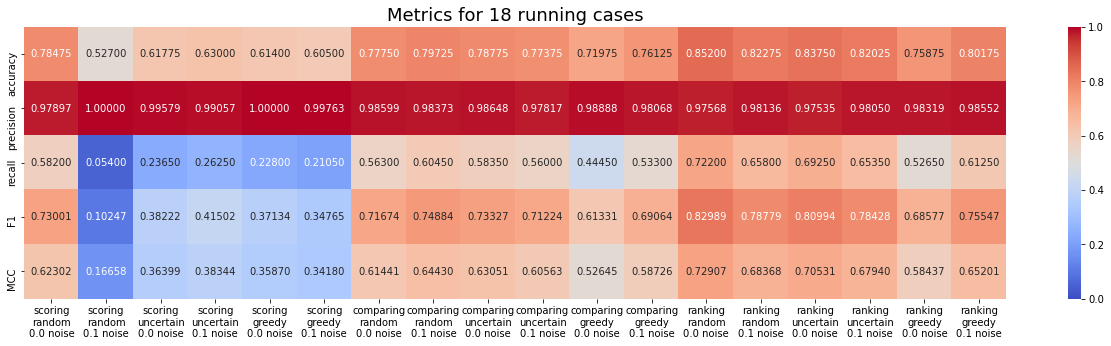

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

running_case = [
    ("score_regression", "acq_random", "noise_0.0"),
    ("score_regression", "acq_random", "noise_0.1"),
    ("score_regression", "acq_uncertainty", "noise_0.0"),
    ("score_regression", "acq_uncertainty", "noise_0.1"),
    ("score_regression", "acq_greedy", "noise_0.0"),
    ("score_regression", "acq_greedy", "noise_0.1"),
    ("bradley_terry", "acq_random", "noise_0.0"),
    ("bradley_terry", "acq_random", "noise_0.1"),
    ("bradley_terry", "acq_uncertainty", "noise_0.0"),
    ("bradley_terry", "acq_uncertainty", "noise_0.1"),
    ("bradley_terry", "acq_greedy", "noise_0.0"),
    ("bradley_terry", "acq_greedy", "noise_0.1"),
    ("rank_listnet", "acq_random", "noise_0.0"),
    ("rank_listnet", "acq_random", "noise_0.1"),
    ("rank_listnet", "acq_uncertainty", "noise_0.0"),
    ("rank_listnet", "acq_uncertainty", "noise_0.1"),
    ("rank_listnet", "acq_greedy", "noise_0.0"),
    ("rank_listnet", "acq_greedy", "noise_0.1")
]

model_name_map = {
    "score_regression": "scoring",
    "bradley_terry": "comparing",
    "rank_listnet": "ranking"
}

acq_name_map = {
    "acq_random": "random",
    "acq_uncertainty": "uncertain",
    "acq_greedy": "greedy"
}

noise_name_map = {
    "noise_0.0": "0.0 noise",
    "noise_0.1": "0.1 noise"
}
metrics = ["accuracy", "precision", "recall", "F1", "MCC"]
REINVENT_round_name = "REINVENT_round_4"
index_threshold = 50

# Initialize a matrix to store the metric values for the heatmap
heatmap_data = np.zeros((len(metrics), len(running_case)))

for i, metric_name in enumerate(metrics):
    for j, case in enumerate(running_case):
        metric_value = models[case[0]][f"{case[1]}_{case[2]}"]["metrics"][REINVENT_round_name][metric_name][index_threshold]
        heatmap_data[i, j] = metric_value

plt.figure(figsize=(22, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".5f", cmap="coolwarm", 
            xticklabels=[f"{model_name_map[case[0]]}\n{acq_name_map[case[1]]}\n{noise_name_map[case[2]]}" for case in running_case],
            yticklabels=metrics,
            # set color bar to range 0 and 1
            vmin=0.0, vmax=1.0)

plt.xticks(rotation=0)
plt.title("Metrics for 18 running cases", fontsize=18)
plt.show()

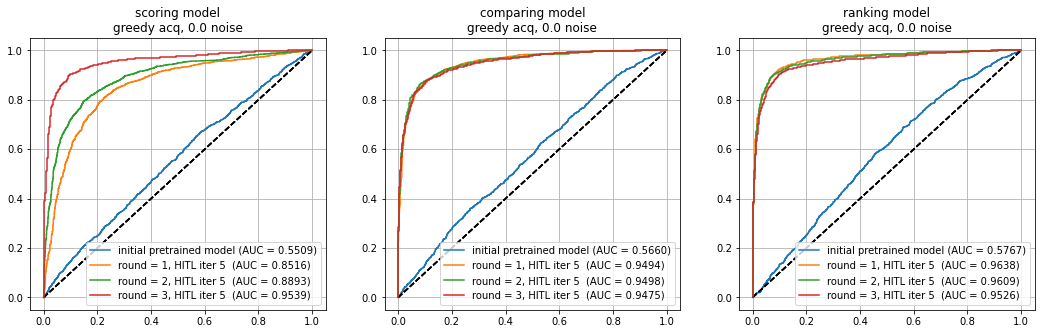

In [36]:
# Plotting 2 x 3 grid
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# flatten ax
ax = ax.flatten()


# subplot title
# fig.suptitle(f"ROC curve for DRD2 classification\nModel performance evolution", fontsize=16)

index = 0

sigma_noise = 0.0
acquisition = "greedy"

model_name_mapping = {
    "score_regression": "scoring",
    "bradley_terry": "comparing",
    "rank_listnet": "ranking"
}
model_names = ["score_regression", "bradley_terry", "rank_listnet"]
for model_name in model_names:
    for REINVENT_round in [1,2,3,4]:
            
        REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
        
        fpr_scoring = models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['fpr']
        tpr_scoring = models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['tpr']
        roc_auc_scoring = models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['roc_auc']

        # Draw a diagonal line
        ax[index].plot([0, 1], [0, 1], 'k--')
        REINVENT_round_actual = f"round = {REINVENT_round - 1}, HITL iter 5 " if REINVENT_round > 1 else "initial pretrained model"
        ax[index].plot(fpr_scoring, tpr_scoring, label=f"{REINVENT_round_actual} (AUC = {roc_auc_scoring:.4f})")

        # turn on grid for each subplot
    
    ax[index].set_title(f"{model_name_mapping[model_name]} model\n{acquisition} acq, {sigma_noise} noise")
    ax[index].grid()
    ax[index].legend(loc='lower right')
    
    index += 1


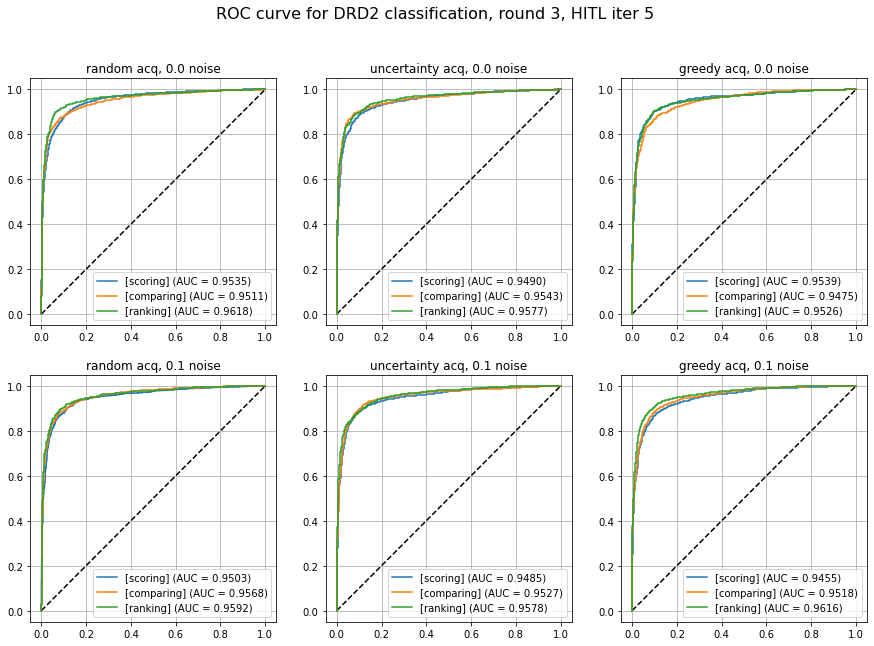

In [37]:
# Plotting 2 x 3 grid
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# flatten ax
ax = ax.flatten()

REINVENT_round = 4
# subplot title
fig.suptitle(f"ROC curve for DRD2 classification, round {REINVENT_round - 1}, HITL iter 5", fontsize=16)

index = 0
for sigma_noise in [0.0, 0.1]:
    for acquisition in ["random", "uncertainty", "greedy"]:
        REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
        
        fpr_scoring = models["score_regression"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['fpr']
        tpr_scoring = models["score_regression"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['tpr']
        roc_auc_scoring = models["score_regression"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['roc_auc']

        fpr_comparing = models["bradley_terry"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['fpr']
        tpr_comparing = models["bradley_terry"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['tpr']
        roc_auc_comparing = models["bradley_terry"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['roc_auc']

        fpr_ranking = models["rank_listnet"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['fpr']
        tpr_ranking = models["rank_listnet"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['tpr']
        roc_auc_ranking = models["rank_listnet"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['roc_auc']

        # Draw a diagonal line
        ax[index].plot([0, 1], [0, 1], 'k--')
        ax[index].plot(fpr_scoring, tpr_scoring, label=f"[scoring] (AUC = {roc_auc_scoring:.4f})")
        ax[index].plot(fpr_comparing, tpr_comparing, label=f"[comparing] (AUC = {roc_auc_comparing:.4f})")
        ax[index].plot(fpr_ranking, tpr_ranking, label=f"[ranking] (AUC = {roc_auc_ranking:.4f})")
        
        # turn on grid for each subplot
        ax[index].grid()
        ax[index].set_title(f"{acquisition} acq, {sigma_noise} noise")
        ax[index].legend(loc='lower right')
        
        index += 1


### Filter functions

In [21]:
from rdkit.Chem import Descriptors
from rdkit.Chem import Crippen
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import QED
from rdkit.Chem import DataStructs
from rdkit.Chem import RDConfig

lower_bounds = {
    "drd2_proba": 0.75,  # No lower limit, set to your preference
    "novelty_score": 0.5,  # No lower limit, set to your preference
    "sa_score": 1.0,  # Lower is better, minimum achievable is 1
    "qed_score": 0.5,  # Minimum acceptable QED score
    "logP": 1,  # No practical lower limit, but logP can be negative
    "mol_weight": 0,  # Molecules can technically weigh very little
    "h_donors": 0,  # Hydrogen bond donors can be zero
    "h_acceptors": 0,  # Hydrogen bond acceptors can be zero
    "tpsa": 0,  # Total polar surface area can be zero
    "rotatable_bonds": 0,  # Rotatable bonds can be zero
    "num_rings": 0  # Number of rings can be zero
}

upper_bounds = {
    "drd2_proba": 1.0,  # Maximum for a probability score
    "novelty_score": 1.0,  # Theoretical maximum for novelty score
    "sa_score": 3.0,  # Upper limit often considered for synthetic accessibility
    "qed_score": 1.0,  # Maximum possible QED score
    "logP": 5.0,  # Lipinski's rule of five
    "mol_weight": 500.0,  # Lipinski's rule of five
    "h_donors": 5,  # Lipinski's rule of five
    "h_acceptors": 10,  # Lipinski's rule of five
    "tpsa": 140.0,  # Veber's rule
    "rotatable_bonds": 10,  # Veber's rule
    "num_rings": 7  # Muegge’s rule
}

def mol_descriptor_filter(props_dict, lower_bounds=lower_bounds, upper_bounds=upper_bounds):
    smiles_list = props_dict["smiles_list"]
    drd2_proba = props_dict["drd2_proba"]
    
    logP = props_dict["logP"]
    mol_weight = props_dict["mol_weight"]
    h_donors = props_dict["h_donors"]
    h_acceptors = props_dict["h_acceptors"]
    tpsa = props_dict["tpsa"]
    rotatable_bonds = props_dict["rotatable_bonds"]
    num_rings = props_dict["num_rings"]

    props_dict_filtered = {}
    percentage_dict = {}
    means_dict = {}

    # Strategy: we need to find the indices that satisfy each condition, and then take the intersection of all of them

    # drd2_proba
    drd2_proba_indices = np.where((drd2_proba > lower_bounds["drd2_proba"]) & (drd2_proba < upper_bounds["drd2_proba"]))[0]
    satisfied_drd2_proba = len(drd2_proba_indices) / len(drd2_proba)
    
    # logP
    logP_indices = np.where((logP > lower_bounds["logP"]) & (logP < upper_bounds["logP"]))[0]
    satisfied_logP = len(logP_indices) / len(logP)

    # mol_weight
    mol_weight_indices = np.where((mol_weight > lower_bounds["mol_weight"]) & (mol_weight < upper_bounds["mol_weight"]))[0]
    satisfied_mol_weight = len(mol_weight_indices) / len(mol_weight)

    # h_donors
    h_donors_indices = np.where((h_donors > lower_bounds["h_donors"]) & (h_donors < upper_bounds["h_donors"]))[0]
    satisfied_h_donors = len(h_donors_indices) / len(h_donors)

    # h_acceptors
    h_acceptors_indices = np.where((h_acceptors > lower_bounds["h_acceptors"]) & (h_acceptors < upper_bounds["h_acceptors"]))[0]
    satisfied_h_acceptors = len(h_acceptors_indices) / len(h_acceptors)

    # tpsa
    tpsa_indices = np.where((tpsa > lower_bounds["tpsa"]) & (tpsa < upper_bounds["tpsa"]))[0]
    satisfied_tpsa = len(tpsa_indices) / len(tpsa)

    # rotatable_bonds
    rotatable_bonds_indices = np.where((rotatable_bonds > lower_bounds["rotatable_bonds"]) & (rotatable_bonds < upper_bounds["rotatable_bonds"]))[0]
    satisfied_rotatable_bonds = len(rotatable_bonds_indices) / len(rotatable_bonds)

    # num_rings
    num_rings_indices = np.where((num_rings > lower_bounds["num_rings"]) & (num_rings < upper_bounds["num_rings"]))[0]
    satisfied_num_rings = len(num_rings_indices) / len(num_rings)

    # Finding the intersection of all index arrays
    common_indices = drd2_proba_indices
    
    for indices in [
        logP_indices,
        mol_weight_indices,
        h_donors_indices,
        h_acceptors_indices,
        tpsa_indices,
        rotatable_bonds_indices,
        num_rings_indices
    ]:
        common_indices = np.intersect1d(common_indices, indices)

    props_dict_filtered["smiles_list"] = smiles_list[common_indices]
    props_dict_filtered["drd2_proba"] = drd2_proba[common_indices]
    props_dict_filtered["logP"] = logP[common_indices]
    props_dict_filtered["mol_weight"] = mol_weight[common_indices]
    props_dict_filtered["h_donors"] = h_donors[common_indices]
    props_dict_filtered["h_acceptors"] = h_acceptors[common_indices]
    props_dict_filtered["tpsa"] = tpsa[common_indices]
    props_dict_filtered["rotatable_bonds"] = rotatable_bonds[common_indices]
    props_dict_filtered["num_rings"] = num_rings[common_indices]

    percentage_dict["smiles_list"] = len(common_indices) / len(smiles_list)
    percentage_dict["drd2_proba"] = satisfied_drd2_proba
    percentage_dict["logP"] = satisfied_logP
    percentage_dict["mol_weight"] = satisfied_mol_weight
    percentage_dict["h_donors"] = satisfied_h_donors
    percentage_dict["h_acceptors"] = satisfied_h_acceptors
    percentage_dict["tpsa"] = satisfied_tpsa
    percentage_dict["rotatable_bonds"] = satisfied_rotatable_bonds
    percentage_dict["num_rings"] = satisfied_num_rings

    means_dict["smiles_list"] = len(common_indices)
    means_dict["drd2_proba"] = np.mean(drd2_proba[common_indices])
    means_dict["logP"] = np.mean(logP[common_indices])
    means_dict["mol_weight"] = np.mean(mol_weight[common_indices])
    means_dict["h_donors"] = np.mean(h_donors[common_indices])
    means_dict["h_acceptors"] = np.mean(h_acceptors[common_indices])
    means_dict["tpsa"] = np.mean(tpsa[common_indices])
    means_dict["rotatable_bonds"] = np.mean(rotatable_bonds[common_indices])
    means_dict["num_rings"] = np.mean(num_rings[common_indices])
    
    return props_dict_filtered, percentage_dict, means_dict

In [23]:
import copy

model_names = ["score_regression", "bradley_terry", "rank_listnet"]
model_names_mapping = {
    "score_regression": "scoring",
    "bradley_terry": "comparing",
    "rank_listnet": "ranking"
}
prop_names = ["smiles_list", "drd2_proba", "logP", "mol_weight", "h_donors", "h_acceptors", "tpsa", "rotatable_bonds", "num_rings"]

filtered_models = copy.deepcopy(models)

summary_percentage = pd.DataFrame(columns=["num_filtered_mols", "drd2_proba", "logP", "mol_weight", "h_donors", "h_acceptors", "tpsa", "rotatable_bonds", "num_rings"])
summary_mean = pd.DataFrame(columns=["num_filtered_mols", "drd2_proba", "logP", "mol_weight", "h_donors", "h_acceptors", "tpsa", "rotatable_bonds", "num_rings"])

for i, model_name in enumerate(model_names):
    for acquisition in ["random", "uncertainty", "greedy"]:
        for sigma_noise in [0.0, 0.1]:
            for REINVENT_round in [4]:
                REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
                props_dict = {}
                for prop_name in prop_names:
                    #print(prop_name)
                    props_dict[prop_name] = models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name][REINVENT_round_name]

                props_dict["smiles_list"] = models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["smiles_list"][REINVENT_round_name]
                
                props_dict_filtered, percentage_dict, means_dict = mol_descriptor_filter(props_dict)
                if REINVENT_round == 4:
                    summary_percentage.loc[f"{model_names_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}", "num_filtered_mols"] = len(props_dict_filtered["smiles_list"])
                    summary_mean.loc[f"{model_names_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}", "num_filtered_mols"] = len(props_dict_filtered["smiles_list"])
                    for prop_name in percentage_dict.keys():
                        if prop_name != "smiles_list":
                            summary_percentage.loc[f"{model_names_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}", prop_name] = percentage_dict[prop_name]
                    for prop_name in means_dict.keys():
                        if prop_name != "smiles_list":
                            summary_mean.loc[f"{model_names_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}", prop_name] = means_dict[prop_name]
                for prop_name in prop_names:
                    filtered_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name][REINVENT_round_name] = props_dict_filtered[prop_name]

print("Summary of percentage of molecules that satisfy each respective threshold at last REINVENT round")
summary_percentage = summary_percentage.apply(pd.to_numeric, errors='coerce')  # Convert all other data to numeric, coercing errors
summary_percentage.head(30)

Summary of percentage of molecules that satisfy each respective threshold at last REINVENT round


,num_filtered_mols,drd2_proba,logP,mol_weight,h_donors,h_acceptors,tpsa,rotatable_bonds,num_rings
scoring | random acq | noise 0.0,164,0.069515,0.480034,0.407719,0.749574,0.901875,0.926224,0.614926,0.771731
scoring | random acq | noise 0.1,242,0.413018,0.539727,0.724114,0.213111,0.997220,0.997915,0.528145,0.996757
scoring | uncertainty acq | noise 0.0,301,0.435421,0.598677,0.627609,0.289523,0.862575,0.984914,0.479231,0.946477
scoring | uncertainty acq | noise 0.1,583,0.403616,0.770891,0.903339,0.446966,0.993359,0.995204,0.914222,0.989670
scoring | greedy acq | noise 0.0,557,0.500494,0.580913,0.668247,0.381545,0.989133,0.999210,0.575380,0.970164
scoring | greedy acq | noise 0.1,659,0.512884,0.731239,0.868671,0.542722,0.994123,0.995931,0.778255,0.995027
comparing | random acq | noise 0.0,365,0.146818,0.772943,0.947486,0.596074,0.990590,0.988263,0.932713,0.986947
comparing | random acq | noise 0.1,490,0.147374,0.738182,0.909495,0.621919,0.993030,0.989798,0.838889,0.980909
comparing | uncertainty acq | noise 0.0,379,0.124685,0.790948,0.949602,0.588146,0.988610,0.988408,0.895172,0.981151
comparing | uncertainty acq | noise 0.1,482,0.166013,0.740830,0.888554,0.633203,0.989549,0.989549,0.858306,0.978394


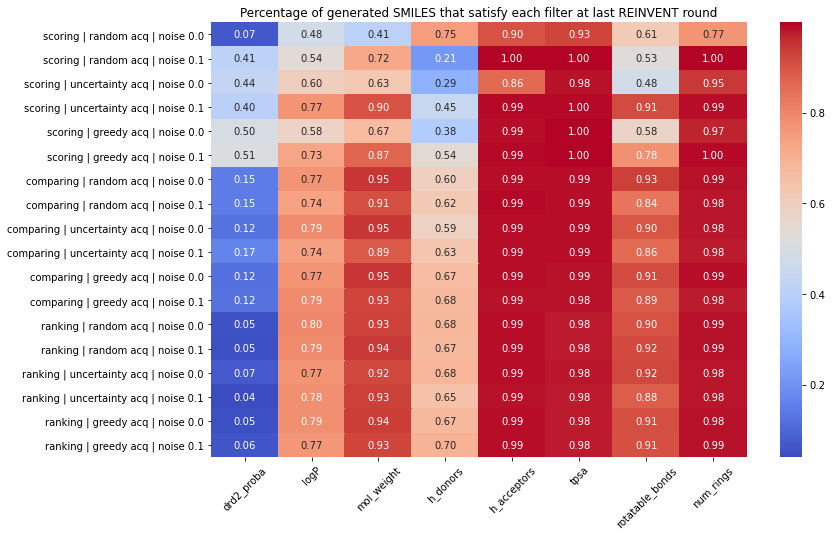

In [24]:
# We'll drop the 'num_filtered_mols' column if you only want to visualize the properties

data_for_heatmap = summary_percentage.drop(['num_filtered_mols'], axis=1)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data_for_heatmap, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Percentage of generated SMILES that satisfy each filter at last REINVENT round')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [25]:
print("Summary of mean of properties of molecules that satisfy each respective threshold at last REINVENT round")
summary_mean.head(30)

Summary of mean of properties of molecules that satisfy each respective threshold at last REINVENT round


,num_filtered_mols,drd2_proba,logP,mol_weight,h_donors,h_acceptors,tpsa,rotatable_bonds,num_rings
scoring | random acq | noise 0.0,164,0.915602,3.7929,419.803299,1.408537,4.591463,54.436037,6.237805,4.402439
scoring | random acq | noise 0.1,242,0.944819,3.723889,386.742698,1.18595,3.863636,36.739545,6.942149,3.512397
scoring | uncertainty acq | noise 0.0,301,0.948118,3.696051,394.874568,1.119601,4.475083,44.720133,6.837209,3.983389
scoring | uncertainty acq | noise 0.1,583,0.950502,3.837635,396.65901,1.154374,3.929674,40.916106,6.171527,3.782161
scoring | greedy acq | noise 0.0,557,0.952338,3.776067,405.203582,1.154399,4.021544,44.131418,6.815081,3.698384
scoring | greedy acq | noise 0.1,659,0.948118,3.839226,400.169068,1.230653,3.963581,42.911472,6.819423,3.537178
comparing | random acq | noise 0.0,365,0.91764,3.718791,375.505225,1.254795,3.575342,40.097041,5.090411,3.841096
comparing | random acq | noise 0.1,490,0.924279,3.749632,379.442647,1.25102,3.563265,41.547347,6.069388,3.846939
comparing | uncertainty acq | noise 0.0,379,0.921341,3.742814,368.462148,1.277045,3.572559,41.926385,5.493404,3.897098
comparing | uncertainty acq | noise 0.1,482,0.925925,3.8617,394.644052,1.288382,3.954357,44.83278,6.126556,4.047718


In [26]:
import copy

model_names = ["score_regression", "bradley_terry", "rank_listnet"]
prop_names = ["smiles_list", "drd2_proba", "logP", "mol_weight", "h_donors", "h_acceptors", "tpsa", "rotatable_bonds", "num_rings"]

model_names_mapping = {
    "score_regression": "scoring",
    "bradley_terry": "comparing",
    "rank_listnet": "ranking"
}
filtered_combined_models = copy.deepcopy(combined_models)

summary_percentage = pd.DataFrame(columns=["num_filtered_mols", "drd2_proba", "logP", "mol_weight", "h_donors", "h_acceptors", "tpsa", "rotatable_bonds", "num_rings"])
summary_mean = pd.DataFrame(columns=["num_filtered_mols", "drd2_proba", "logP", "mol_weight", "h_donors", "h_acceptors", "tpsa", "rotatable_bonds", "num_rings"])

for i, model_name in enumerate(model_names):
    for acquisition in ["random", "uncertainty", "greedy"]:
        for sigma_noise in [0.0, 0.1]:

            props_dict = {}
            for prop_name in prop_names:
                #print(prop_name)
                props_dict[prop_name] = combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name]

            props_dict["smiles_list"] = combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["smiles_list"]
            
            threshold_dict = {} # We will use the default thresholds
            props_dict_filtered, percentage_dict, means_dict = mol_descriptor_filter(props_dict)
            
            summary_percentage.loc[f"{model_names_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}", "num_filtered_mols"] = len(props_dict_filtered["smiles_list"])
            summary_mean.loc[f"{model_names_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}", "num_filtered_mols"] = len(props_dict_filtered["smiles_list"])

            summary_percentage.loc[f"{model_names_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}", "all filters"] = percentage_dict["smiles_list"]
            for prop_name in percentage_dict.keys():
                if prop_name != "smiles_list":
                    summary_percentage.loc[f"{model_names_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}", prop_name] = percentage_dict[prop_name]
            
            for prop_name in means_dict.keys():
                if prop_name != "smiles_list":
                    summary_mean.loc[f"{model_names_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}", prop_name] = means_dict[prop_name]
            for prop_name in prop_names:
                filtered_combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name] = props_dict_filtered[prop_name]

print("Summary of percentage of molecules that satisfy each respective threshold at all REINVENT rounds")
summary_percentage = summary_percentage.apply(pd.to_numeric, errors='coerce')  # Convert all other data to numeric, coercing errors
summary_percentage.head(30)

Summary of percentage of molecules that satisfy each respective threshold at all REINVENT rounds


,num_filtered_mols,drd2_proba,logP,mol_weight,h_donors,h_acceptors,tpsa,rotatable_bonds,num_rings,all filters
scoring | random acq | noise 0.0,424,0.110876,0.537439,0.521684,0.717262,0.928003,0.945536,0.673471,0.828477,0.035914
scoring | random acq | noise 0.1,291,0.162348,0.688090,0.845976,0.542818,0.986442,0.971083,0.758280,0.977433,0.024970
scoring | uncertainty acq | noise 0.0,392,0.138001,0.729723,0.845957,0.600370,0.949964,0.973879,0.794311,0.972567,0.023378
scoring | uncertainty acq | noise 0.1,659,0.143295,0.776230,0.921686,0.614618,0.988409,0.976398,0.909014,0.983785,0.039577
scoring | greedy acq | noise 0.0,642,0.175271,0.714808,0.836016,0.608671,0.986789,0.977105,0.801193,0.977554,0.041172
scoring | greedy acq | noise 0.1,765,0.163110,0.765872,0.917070,0.659838,0.989462,0.978793,0.873413,0.985404,0.050072
comparing | random acq | noise 0.0,553,0.098602,0.773331,0.931315,0.643805,0.989340,0.985016,0.914924,0.984463,0.027806
comparing | random acq | noise 0.1,699,0.100953,0.755544,0.917210,0.661816,0.990617,0.986553,0.871801,0.980783,0.035073
comparing | uncertainty acq | noise 0.0,578,0.090226,0.779649,0.936842,0.634035,0.989173,0.986165,0.900150,0.982105,0.028972
comparing | uncertainty acq | noise 0.1,673,0.108253,0.755315,0.900120,0.674539,0.988618,0.985058,0.884126,0.979242,0.033744


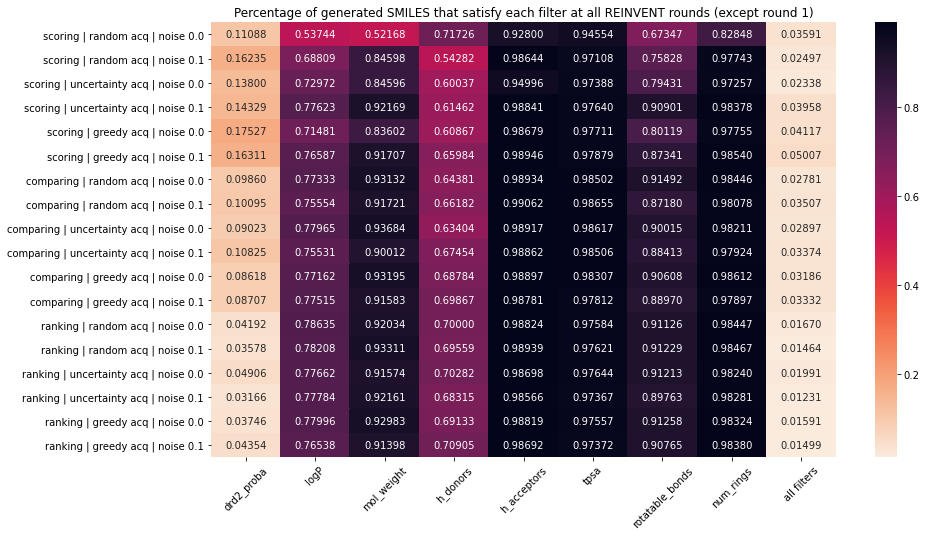

In [27]:
# We'll drop the 'num_filtered_mols' column if you only want to visualize the properties

data_for_heatmap = summary_percentage.drop(['num_filtered_mols'], axis=1)

# Create the heatmap
plt.figure(figsize=(14, 8))
# We use heatmap of only 1 color range since this is not contrastive
sns.heatmap(data_for_heatmap, annot=True, cmap= 'rocket_r', fmt=".5f")
plt.title(f'Percentage of generated SMILES that satisfy each filter at all REINVENT rounds (except round 1)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [28]:
print("Summary of mean of properties of molecules that satisfy all thresholds at all REINVENT rounds except round 1")
summary_mean.head(30)

Summary of mean of properties of molecules that satisfy all thresholds at all REINVENT rounds except round 1


,num_filtered_mols,drd2_proba,logP,mol_weight,h_donors,h_acceptors,tpsa,rotatable_bonds,num_rings
scoring | random acq | noise 0.0,424,0.920412,3.806492,399.031347,1.325472,4.101415,47.666533,5.959906,4.176887
scoring | random acq | noise 0.1,291,0.935555,3.717701,382.785416,1.206186,3.835052,38.221993,6.621993,3.549828
scoring | uncertainty acq | noise 0.0,392,0.937466,3.680849,388.770702,1.201531,4.262755,45.588316,6.413265,3.954082
scoring | uncertainty acq | noise 0.1,659,0.945035,3.801789,391.536566,1.186646,3.877086,41.509059,6.037936,3.764795
scoring | greedy acq | noise 0.0,642,0.946337,3.729932,399.774115,1.196262,3.978193,44.726355,6.58567,3.71028
scoring | greedy acq | noise 0.1,765,0.942019,3.817506,396.610037,1.258824,3.932026,43.743725,6.542484,3.592157
comparing | random acq | noise 0.0,553,0.911298,3.683283,375.49221,1.309222,3.611212,41.989313,5.133816,3.851718
comparing | random acq | noise 0.1,699,0.919042,3.738802,379.787501,1.270386,3.620887,42.834134,5.896996,3.849785
comparing | uncertainty acq | noise 0.0,578,0.917657,3.705888,370.104322,1.299308,3.576125,43.105069,5.314879,3.901384
comparing | uncertainty acq | noise 0.1,673,0.919829,3.814289,390.232052,1.325409,3.89153,45.853299,5.875186,4.022288


### Calculating novelty score

In [38]:
from multiprocessing import Pool
from rdkit import Chem

def get_mol(smiles_or_mol):
    '''
    Loads SMILES/molecule into RDKit's object
    '''
    if isinstance(smiles_or_mol, str):
        if len(smiles_or_mol) == 0:
            return None
        mol = Chem.MolFromSmiles(smiles_or_mol)
        if mol is None:
            return None
        try:
            Chem.SanitizeMol(mol)
        except ValueError:
            return None
        return mol
    return smiles_or_mol

def canonic_smiles(smiles_or_mol):
    mol = get_mol(smiles_or_mol)
    if mol is None:
        return None
    return Chem.MolToSmiles(mol)

def mapper(n_jobs):
    '''
    Returns function for map call.
    If n_jobs == 1, will use standard map
    If n_jobs > 1, will use multiprocessing pool
    If n_jobs is a pool object, will return its map function
    '''
    if n_jobs == 1:
        def _mapper(*args, **kwargs):
            return list(map(*args, **kwargs))

        return _mapper
    if isinstance(n_jobs, int):
        pool = Pool(n_jobs)

        def _mapper(*args, **kwargs):
            try:
                result = pool.map(*args, **kwargs)
            finally:
                pool.terminate()
            return result

        return _mapper
    return n_jobs.map

def novelty_score(gen, train, n_jobs=1): # note that gen is a list of generated SMILES, train is a list of training SMILES
    gen_smiles = mapper(n_jobs)(canonic_smiles, gen)
    gen_smiles_set = set(gen_smiles) - {None}
    train_set = set(train)
    return len(gen_smiles_set - train_set) / len(gen_smiles_set)

In [67]:
import copy

model_names = ["score_regression", "bradley_terry", "rank_listnet"]
model_names_mapping = {
    "score_regression": "scoring",
    "bradley_terry": "comparing",
    "rank_listnet": "ranking"
}

initial_training_dataset_path = "/home/springnuance/reinvent-hitl/Base-Code-Binh/data/drd2_final_train_small.csv"
final_testing_dataset_path = "/home/springnuance/reinvent-hitl/Base-Code-Binh/data/drd2_final_large.csv"

reference_dataset = pd.read_csv(final_testing_dataset_path)
reference_smiles = reference_dataset["smiles"].tolist()

unfiltered_novelty_score_dict = {
    "score_regression": {},
    "bradley_terry": {},
    "rank_listnet": {}
}

filtered_novelty_score_dict = {
    "score_regression": {},
    "bradley_terry": {},
    "rank_listnet": {}
}

if not os.path.exists("results_scores_n_steps_100/unfiltered_novelty_score_dict.npy"):
    print("(unfiltered) The novelty score is")
    for i, model_name in enumerate(model_names):
        for acquisition in ["random", "uncertainty", "greedy"]:
            for sigma_noise in [0.0, 0.1]:
                unfiltered_generated_smiles_list = combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["smiles_list"]
                novelty_score_case_mean = novelty_score(unfiltered_generated_smiles_list, reference_smiles, n_jobs=8)
                unfiltered_novelty_score_dict[model_name][f"acq_{acquisition}_noise_{sigma_noise}"] = novelty_score_case_mean
                print(f"{model_name_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}: {novelty_score_case_mean}")
    np.save("results_scores_n_steps_100/unfiltered_novelty_score_dict.npy", unfiltered_novelty_score_dict)

else:
    unfiltered_novelty_score_dict = np.load("results_scores_n_steps_100/unfiltered_novelty_score_dict.npy", allow_pickle=True).tolist()

if not os.path.exists("results_scores_n_steps_100/filtered_novelty_score_dict.npy"):

    print("(filtered) The novelty score is")

    for i, model_name in enumerate(model_names):
        for acquisition in ["random", "uncertainty", "greedy"]:
            for sigma_noise in [0.0, 0.1]:
                unfiltered_generated_smiles_list = filtered_combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["smiles_list"]
                novelty_score_case_mean = novelty_score(unfiltered_generated_smiles_list, reference_smiles, n_jobs=8)
                filtered_novelty_score_dict[model_name][f"acq_{acquisition}_noise_{sigma_noise}"] = novelty_score_case_mean
                print(f"{model_name_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}: {novelty_score_case_mean}")
    np.save("results_scores_n_steps_100/filtered_novelty_score_dict.npy", filtered_novelty_score_dict)

else:
    filtered_novelty_score_dict = np.load("results_scores_n_steps_100/filtered_novelty_score_dict.npy", allow_pickle=True).tolist()

print("Mean novelty score for each model (unfiltered)")
print("Scoring model", np.mean(list(unfiltered_novelty_score_dict["score_regression"].values())))
print("Comparing model", np.mean(list(unfiltered_novelty_score_dict["bradley_terry"].values())))
print("Ranking model", np.mean(list(unfiltered_novelty_score_dict["rank_listnet"].values())))

print("Mean novelty score for each model (filtered)")
print("Scoring model", np.mean(list(filtered_novelty_score_dict["score_regression"].values())))
print("Comparing model", np.mean(list(filtered_novelty_score_dict["bradley_terry"].values())))
print("Ranking model", np.mean(list(filtered_novelty_score_dict["rank_listnet"].values())))


(unfiltered) The novelty score is
scoring | random acq | noise 0.0: 0.9968654693324297
scoring | random acq | noise 0.1: 0.9874624302275655
scoring | uncertainty acq | noise 0.0: 0.9865187306132188
scoring | uncertainty acq | noise 0.1: 0.9819056206792907
scoring | greedy acq | noise 0.0: 0.9866529774127311
scoring | greedy acq | noise 0.1: 0.9824434981984933
comparing | random acq | noise 0.0: 0.9857373248664449
comparing | random acq | noise 0.1: 0.9869901547116737
comparing | uncertainty acq | noise 0.0: 0.9856942074088947
comparing | uncertainty acq | noise 0.1: 0.9898650343685715
comparing | greedy acq | noise 0.0: 0.9864567716141929
comparing | greedy acq | noise 0.1: 0.9882529367658085
ranking | random acq | noise 0.0: 0.9844612138915937
ranking | random acq | noise 0.1: 0.9842936197916666
ranking | uncertainty acq | noise 0.0: 0.9865660132310564
ranking | uncertainty acq | noise 0.1: 0.9861320102484851
ranking | greedy acq | noise 0.0: 0.9847703366770906
ranking | greedy acq | 

### Calculating diversity score

In [51]:
import os
from collections import Counter
from functools import partial
from multiprocessing import Pool
import numpy as np
import pandas as pd
import scipy.sparse
import torch
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect as Morgan
from rdkit.Chem.QED import qed
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors

def mapper(n_jobs):
    '''
    Returns function for map call.
    If n_jobs == 1, will use standard map
    If n_jobs > 1, will use multiprocessing pool
    If n_jobs is a pool object, will return its map function
    '''
    if n_jobs == 1:
        def _mapper(*args, **kwargs):
            return list(map(*args, **kwargs))

        return _mapper
    if isinstance(n_jobs, int):
        pool = Pool(n_jobs)

        def _mapper(*args, **kwargs):
            try:
                result = pool.map(*args, **kwargs)
            finally:
                pool.terminate()
            return result

        return _mapper
    return n_jobs.map

def get_mol(smiles_or_mol):
    '''
    Loads SMILES/molecule into RDKit's object
    '''
    if isinstance(smiles_or_mol, str):
        if len(smiles_or_mol) == 0:
            return None
        mol = Chem.MolFromSmiles(smiles_or_mol)
        if mol is None:
            return None
        try:
            Chem.SanitizeMol(mol)
        except ValueError:
            return None
        return mol
    return smiles_or_mol

def fingerprint(smiles_or_mol, fp_type='maccs', dtype=None, morgan__r=2,
                morgan__n=1024, *args, **kwargs):
    """
    Generates fingerprint for SMILES
    If smiles is invalid, returns None
    Returns numpy array of fingerprint bits

    Parameters:
        smiles: SMILES string
        type: type of fingerprint: [MACCS|morgan]
        dtype: if not None, specifies the dtype of returned array
    """
    fp_type = fp_type.lower()
    molecule = get_mol(smiles_or_mol, *args, **kwargs)
    if molecule is None:
        return None
    if fp_type == 'maccs':
        keys = MACCSkeys.GenMACCSKeys(molecule)
        keys = np.array(keys.GetOnBits())
        fingerprint = np.zeros(166, dtype='uint8')
        if len(keys) != 0:
            fingerprint[keys - 1] = 1  # We drop 0-th key that is always zero
    elif fp_type == 'morgan':
        fingerprint = np.asarray(Morgan(molecule, morgan__r, nBits=morgan__n),
                                 dtype='uint8')
    else:
        raise ValueError("Unknown fingerprint type {}".format(fp_type))
    if dtype is not None:
        fingerprint = fingerprint.astype(dtype)
    return fingerprint


def fingerprints(smiles_mols_array, n_jobs=1, already_unique=False, *args,
                 **kwargs):
    '''
    Computes fingerprints of smiles np.array/list/pd.Series with n_jobs workers
    e.g.fingerprints(smiles_mols_array, type='morgan', n_jobs=10)
    Inserts np.NaN to rows corresponding to incorrect smiles.
    IMPORTANT: if there is at least one np.NaN, the dtype would be float
    Parameters:
        smiles_mols_array: list/array/pd.Series of smiles or already computed
            RDKit molecules
        n_jobs: number of parralel workers to execute
        already_unique: flag for performance reasons, if smiles array is big
            and already unique. Its value is set to True if smiles_mols_array
            contain RDKit molecules already.
    '''
    if isinstance(smiles_mols_array, pd.Series):
        smiles_mols_array = smiles_mols_array.values
    else:
        smiles_mols_array = np.asarray(smiles_mols_array)
    if not isinstance(smiles_mols_array[0], str):
        already_unique = True

    if not already_unique:
        smiles_mols_array, inv_index = np.unique(smiles_mols_array,
                                                 return_inverse=True)

    fps = mapper(n_jobs)(
        partial(fingerprint, *args, **kwargs), smiles_mols_array
    )

    length = 1
    for fp in fps:
        if fp is not None:
            length = fp.shape[-1]
            first_fp = fp
            break
    fps = [fp if fp is not None else np.array([np.NaN]).repeat(length)[None, :]
           for fp in fps]
    if scipy.sparse.issparse(first_fp):
        fps = scipy.sparse.vstack(fps).tocsr()
    else:
        fps = np.vstack(fps)
    if not already_unique:
        return fps[inv_index]
    return fps

def average_agg_tanimoto(stock_vecs, gen_vecs,
                         batch_size=5000, agg='max',
                         device='cpu', p=1):
    """
    For each molecule in gen_vecs finds closest molecule in stock_vecs.
    Returns average tanimoto score for between these molecules

    Parameters:
        stock_vecs: numpy array <n_vectors x dim>
        gen_vecs: numpy array <n_vectors' x dim>
        agg: max or mean
        p: power for averaging: (mean x^p)^(1/p)
    """
    assert agg in ['max', 'mean'], "Can aggregate only max or mean"
    agg_tanimoto = np.zeros(len(gen_vecs))
    total = np.zeros(len(gen_vecs))
    for j in range(0, stock_vecs.shape[0], batch_size):
        x_stock = torch.tensor(stock_vecs[j:j + batch_size]).to(device).float()
        for i in range(0, gen_vecs.shape[0], batch_size):
            y_gen = torch.tensor(gen_vecs[i:i + batch_size]).to(device).float()
            y_gen = y_gen.transpose(0, 1)
            tp = torch.mm(x_stock, y_gen)
            jac = (tp / (x_stock.sum(1, keepdim=True) +
                         y_gen.sum(0, keepdim=True) - tp)).cpu().numpy()
            jac[np.isnan(jac)] = 1
            if p != 1:
                jac = jac**p
            if agg == 'max':
                agg_tanimoto[i:i + y_gen.shape[1]] = np.maximum(
                    agg_tanimoto[i:i + y_gen.shape[1]], jac.max(0))
            elif agg == 'mean':
                agg_tanimoto[i:i + y_gen.shape[1]] += jac.sum(0)
                total[i:i + y_gen.shape[1]] += jac.shape[0]
    if agg == 'mean':
        agg_tanimoto /= total
    if p != 1:
        agg_tanimoto = (agg_tanimoto)**(1/p)
    return np.mean(agg_tanimoto)

def internal_diversity_score(gen, n_jobs=1, device='cpu', fp_type='morgan', agg="mean",
                       gen_fps=None, p=1):
    """
    Computes internal diversity as:
    1/|A|^2 sum_{x, y in AxA} (1-tanimoto(x, y))
    """
    if gen_fps is None:
        gen_fps = fingerprints(gen, fp_type=fp_type, n_jobs=n_jobs)
    return 1 - (average_agg_tanimoto(gen_fps, gen_fps,
                                     agg=agg, device=device, p=p)).mean()

In [64]:
import copy

model_names = ["score_regression", "bradley_terry", "rank_listnet"]
model_names_mapping = {
    "score_regression": "scoring",
    "bradley_terry": "comparing",
    "rank_listnet": "ranking"
}

model_names = ["score_regression", "bradley_terry", "rank_listnet"]
model_names_mapping = {
    "score_regression": "scoring",
    "bradley_terry": "comparing",
    "rank_listnet": "ranking"
}

unfiltered_diversity_score_dict = {
    "score_regression": {},
    "bradley_terry": {},
    "rank_listnet": {}
}

filtered_diversity_score_dict = {
    "score_regression": {},
    "bradley_terry": {},
    "rank_listnet": {}
}

if not os.path.exists("results_scores_n_steps_100/unfiltered_diversity_score_dict.npy"):
    print("(unfiltered) The diversity score is")

    for i, model_name in enumerate(model_names):
        for acquisition in ["random", "uncertainty", "greedy"]:
            for sigma_noise in [0.0, 0.1]:
                unfiltered_generated_smiles_list = combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["smiles_list"]
                diversity_score_case_mean = internal_diversity_score(unfiltered_generated_smiles_list, n_jobs=4)
                unfiltered_diversity_score_dict[model_name][f"acq_{acquisition}_noise_{sigma_noise}"] = diversity_score_case_mean
                print(f"{model_name_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}: {diversity_score_case_mean}")
    np.save("results_scores_n_steps_100/unfiltered_diversity_score_dict.npy", unfiltered_diversity_score_dict)

else:
    unfiltered_diversity_score_dict = np.load("results_scores_n_steps_100/unfiltered_diversity_score_dict.npy", allow_pickle=True).tolist()

if not os.path.exists("results_scores_n_steps_100/filtered_diversity_score_dict.npy"):

    print("(filtered) The diversity score is")

    for i, model_name in enumerate(model_names):
        for acquisition in ["random", "uncertainty", "greedy"]:
            for sigma_noise in [0.0, 0.1]:
                unfiltered_generated_smiles_list = filtered_combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["smiles_list"]
                diversity_score_case_mean = internal_diversity_score(unfiltered_generated_smiles_list, n_jobs=4)
                filtered_diversity_score_dict[model_name][f"acq_{acquisition}_noise_{sigma_noise}"] = diversity_score_case_mean
                print(f"{model_name_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}: {diversity_score_case_mean}")
    np.save("results_scores_n_steps_100/filtered_diversity_score_dict.npy", filtered_diversity_score_dict)

else:
    filtered_diversity_score_dict = np.load("results_scores_n_steps_100/filtered_diversity_score_dict.npy", allow_pickle=True).tolist()

print("Mean diversity score for each model (unfiltered)")
print("Scoring model", np.mean(list(unfiltered_diversity_score_dict["score_regression"].values())))
print("Comparing model", np.mean(list(unfiltered_diversity_score_dict["bradley_terry"].values())))
print("Ranking model", np.mean(list(unfiltered_diversity_score_dict["rank_listnet"].values())))

print("Mean diversity score for each model (filtered)")
print("Scoring model", np.mean(list(filtered_diversity_score_dict["score_regression"].values())))
print("Comparing model", np.mean(list(filtered_diversity_score_dict["bradley_terry"].values())))
print("Ranking model", np.mean(list(filtered_diversity_score_dict["rank_listnet"].values())))


(unfiltered) The diversity score is
scoring | random acq | noise 0.0: 0.8560042899365721
scoring | random acq | noise 0.1: 0.8542099848540791
scoring | uncertainty acq | noise 0.0: 0.8634190513953416
scoring | uncertainty acq | noise 0.1: 0.87393555603626
scoring | greedy acq | noise 0.0: 0.8628977268960099
scoring | greedy acq | noise 0.1: 0.8685194511599386
comparing | random acq | noise 0.0: 0.8774655761416996
comparing | random acq | noise 0.1: 0.8748928032292373
comparing | uncertainty acq | noise 0.0: 0.8794624613528739
comparing | uncertainty acq | noise 0.1: 0.8768182393107536
comparing | greedy acq | noise 0.0: 0.8801037294480057
comparing | greedy acq | noise 0.1: 0.8791778111256844
ranking | random acq | noise 0.0: 0.8788744380168482
ranking | random acq | noise 0.1: 0.8827013826429673
ranking | uncertainty acq | noise 0.0: 0.8796944008841513
ranking | uncertainty acq | noise 0.1: 0.8827103999651065
ranking | greedy acq | noise 0.0: 0.8816521422941629
ranking | greedy acq | 

### Calculating SA score

In [61]:
def sa_score(gen):
    from rdkit.Chem import RDConfig
    import os
    import sys
    sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
    # now you can import sascore!
    import sascorer

    sa_scores_list = []
    for smiles in gen:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            sa_scores_list.append(sascorer.calculateScore(mol))
        else:
            sa_scores_list.append(None)
    return sa_scores_list

import copy

model_names = ["score_regression", "bradley_terry", "rank_listnet"]
model_names_mapping = {
    "score_regression": "scoring",
    "bradley_terry": "comparing",
    "rank_listnet": "ranking"
}

model_names = ["score_regression", "bradley_terry", "rank_listnet"]
model_names_mapping = {
    "score_regression": "scoring",
    "bradley_terry": "comparing",
    "rank_listnet": "ranking"
}

unfiltered_sa_score_dict_list = {
    "score_regression": {},
    "bradley_terry": {},
    "rank_listnet": {}
}

unfiltered_sa_score_dict = {
    "score_regression": {},
    "bradley_terry": {},
    "rank_listnet": {}
}

filtered_sa_score_dict_list = {
    "score_regression": {},
    "bradley_terry": {},
    "rank_listnet": {}
}

filtered_sa_score_dict = {
    "score_regression": {},
    "bradley_terry": {},
    "rank_listnet": {}
}

if not os.path.exists("results_scores_n_steps_100/unfiltered_sa_score_dict_list.npy"):
    print("(unfiltered) The SA score is")

    for i, model_name in enumerate(model_names):
        for acquisition in ["random", "uncertainty", "greedy"]:
            for sigma_noise in [0.0, 0.1]:
                unfiltered_generated_smiles_list = combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["smiles_list"]
                sa_scores_case_list = sa_score(unfiltered_generated_smiles_list)
                unfiltered_sa_score_dict_list[model_name][f"acq_{acquisition}_noise_{sigma_noise}"] = sa_scores_case_list
                sa_score_case_mean = np.mean(sa_scores_case_list)
                unfiltered_sa_score_dict[model_name][f"acq_{acquisition}_noise_{sigma_noise}"] = sa_score_case_mean
                print(f"{model_name_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}: {sa_score_case_mean}")
    np.save("results_scores_n_steps_100/unfiltered_sa_score_dict_list.npy", unfiltered_sa_score_dict_list)
    np.save("results_scores_n_steps_100/unfiltered_sa_score_dict.npy", unfiltered_sa_score_dict)

else:
    unfiltered_sa_score_dict_list = np.load("results_scores_n_steps_100/unfiltered_sa_score_dict_list.npy", allow_pickle=True).tolist()
    unfiltered_sa_score_dict = np.load("results_scores_n_steps_100/unfiltered_sa_score_dict.npy", allow_pickle=True).tolist()

if not os.path.exists("results_scores_n_steps_100/filtered_sa_score_dict_list.npy"):

    print("(filtered) The SA score is")

    for i, model_name in enumerate(model_names):
        for acquisition in ["random", "uncertainty", "greedy"]:
            for sigma_noise in [0.0, 0.1]:
                filtered_generated_smiles_list = filtered_combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["smiles_list"]
                sa_scores_case_list = sa_score(filtered_generated_smiles_list)
                filtered_sa_score_dict_list[model_name][f"acq_{acquisition}_noise_{sigma_noise}"] = sa_scores_case_list
                sa_score_case_mean = np.mean(sa_scores_case_list)
                filtered_sa_score_dict[model_name][f"acq_{acquisition}_noise_{sigma_noise}"] = sa_score_case_mean
                print(f"{model_name_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}: {sa_score_case_mean}")
    np.save("results_scores_n_steps_100/filtered_sa_score_dict_list.npy", filtered_sa_score_dict_list)
    np.save("results_scores_n_steps_100/filtered_sa_score_dict.npy", filtered_sa_score_dict)

else:
    filtered_sa_score_dict_list = np.load("results_scores_n_steps_100/filtered_sa_score_dict_list.npy", allow_pickle=True).tolist()
    filtered_sa_score_dict = np.load("results_scores_n_steps_100/filtered_sa_score_dict.npy", allow_pickle=True).tolist()

print("Mean SA score for each model (unfiltered)")
print("Scoring model", np.mean(list(unfiltered_sa_score_dict["score_regression"].values())))
print("Comparing model", np.mean(list(unfiltered_sa_score_dict["bradley_terry"].values())))
print("Ranking model", np.mean(list(unfiltered_sa_score_dict["rank_listnet"].values())))

print("Mean SA score for each model (filtered)")
print("Scoring model", np.mean(list(filtered_sa_score_dict["score_regression"].values())))
print("Comparing model", np.mean(list(filtered_sa_score_dict["bradley_terry"].values())))
print("Ranking model", np.mean(list(filtered_sa_score_dict["rank_listnet"].values())))

(unfiltered) The SA score is
scoring | random acq | noise 0.0: 3.2328234516736765
scoring | random acq | noise 0.1: 2.667376979279872
scoring | uncertainty acq | noise 0.0: 2.7920201846714425
scoring | uncertainty acq | noise 0.1: 2.7189334524311595
scoring | greedy acq | noise 0.0: 2.7739900942965168
scoring | greedy acq | noise 0.1: 2.6921636759065404
comparing | random acq | noise 0.0: 2.8043592731410776
comparing | random acq | noise 0.1: 2.7950692449729866
comparing | uncertainty acq | noise 0.0: 2.858165219356243
comparing | uncertainty acq | noise 0.1: 2.8225630069315626
comparing | greedy acq | noise 0.0: 2.790532028088887
comparing | greedy acq | noise 0.1: 2.879538197779238
ranking | random acq | noise 0.0: 2.8730440412013287
ranking | random acq | noise 0.1: 2.8867091036001344
ranking | uncertainty acq | noise 0.0: 2.8636325653710597
ranking | uncertainty acq | noise 0.1: 2.9078337214375236
ranking | greedy acq | noise 0.0: 2.881927707211044
ranking | greedy acq | noise 0.1:

### Calculating QED score

In [60]:
def qed_score(gen):
    import rdkit.Chem as Chem

    qed_scores_list = []
    for smiles in gen:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            qed_scores_list.append(Chem.QED.qed(mol))
        else:
            qed_scores_list.append(None)
    return qed_scores_list

model_names = ["score_regression", "bradley_terry", "rank_listnet"]
model_names_mapping = {
    "score_regression": "scoring",
    "bradley_terry": "comparing",
    "rank_listnet": "ranking"
}

unfiltered_qed_score_dict_list = {
    "score_regression": {},
    "bradley_terry": {},
    "rank_listnet": {}
}

unfiltered_qed_score_dict = {
    "score_regression": {},
    "bradley_terry": {},
    "rank_listnet": {}
}

filtered_qed_score_dict_list = {
    "score_regression": {},
    "bradley_terry": {},
    "rank_listnet": {}
}

filtered_qed_score_dict = {
    "score_regression": {},
    "bradley_terry": {},
    "rank_listnet": {}
}

if not os.path.exists("results_scores_n_steps_100/unfiltered_qed_score_dict_list.npy"):
    print("(unfiltered) The QED score is")

    for i, model_name in enumerate(model_names):
        for acquisition in ["random", "uncertainty", "greedy"]:
            for sigma_noise in [0.0, 0.1]:
                unfiltered_generated_smiles_list = combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["smiles_list"]
                qed_scores_case_list = qed_score(unfiltered_generated_smiles_list)
                unfiltered_qed_score_dict_list[model_name][f"acq_{acquisition}_noise_{sigma_noise}"] = qed_scores_case_list
                qed_score_case_mean = np.mean(qed_scores_case_list)
                unfiltered_qed_score_dict[model_name][f"acq_{acquisition}_noise_{sigma_noise}"] = qed_score_case_mean
                print(f"{model_name_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}: {qed_score_case_mean}")
    np.save("results_scores_n_steps_100/unfiltered_qed_score_dict_list.npy", unfiltered_qed_score_dict_list)
    np.save("results_scores_n_steps_100/unfiltered_qed_score_dict.npy", unfiltered_qed_score_dict)

else:
    unfiltered_qed_score_dict_list = np.load("results_scores_n_steps_100/unfiltered_qed_score_dict_list.npy", allow_pickle=True).tolist()
    unfiltered_qed_score_dict = np.load("results_scores_n_steps_100/unfiltered_qed_score_dict.npy", allow_pickle=True).tolist()

if not os.path.exists("results_scores_n_steps_100/filtered_qed_score_dict_list.npy"):

    print("(filtered) The QED score is")

    for i, model_name in enumerate(model_names):
        for acquisition in ["random", "uncertainty", "greedy"]:
            for sigma_noise in [0.0, 0.1]:
                filtered_generated_smiles_list = filtered_combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["smiles_list"]
                qed_scores_case_list = qed_score(filtered_generated_smiles_list)
                filtered_qed_score_dict_list[model_name][f"acq_{acquisition}_noise_{sigma_noise}"] = qed_scores_case_list
                qed_score_case_mean = np.mean(qed_scores_case_list)
                filtered_qed_score_dict[model_name][f"acq_{acquisition}_noise_{sigma_noise}"] = qed_score_case_mean
                print(f"{model_name_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}: {qed_score_case_mean}")
    np.save("results_scores_n_steps_100/filtered_qed_score_dict_list.npy", filtered_qed_score_dict_list)
    np.save("results_scores_n_steps_100/filtered_qed_score_dict.npy", filtered_qed_score_dict)

else:
    filtered_qed_score_dict_list = np.load("results_scores_n_steps_100/filtered_qed_score_dict_list.npy", allow_pickle=True).tolist()
    filtered_qed_score_dict = np.load("results_scores_n_steps_100/filtered_qed_score_dict.npy", allow_pickle=True).tolist()

print("Mean QED score for each model (unfiltered)")
print("Scoring model", np.mean(list(unfiltered_qed_score_dict["score_regression"].values())))
print("Comparing model", np.mean(list(unfiltered_qed_score_dict["bradley_terry"].values())))
print("Ranking model", np.mean(list(unfiltered_qed_score_dict["rank_listnet"].values())))

print("Mean QED score for each model (filtered)")
print("Scoring model", np.mean(list(filtered_qed_score_dict["score_regression"].values())))
print("Comparing model", np.mean(list(filtered_qed_score_dict["bradley_terry"].values())))
print("Ranking model", np.mean(list(filtered_qed_score_dict["rank_listnet"].values())))

(unfiltered) The QED score is
scoring | random acq | noise 0.0: 0.41350759536158715
scoring | random acq | noise 0.1: 0.5624890427701037
scoring | uncertainty acq | noise 0.0: 0.5693758340998741
scoring | uncertainty acq | noise 0.1: 0.630939670625774
scoring | greedy acq | noise 0.0: 0.5740543821728611
scoring | greedy acq | noise 0.1: 0.6144507083516665
comparing | random acq | noise 0.0: 0.6426149844879174
comparing | random acq | noise 0.1: 0.6299290949624641
comparing | uncertainty acq | noise 0.0: 0.6451874214719445
comparing | uncertainty acq | noise 0.1: 0.6132680216668924
comparing | greedy acq | noise 0.0: 0.6363189211739884
comparing | greedy acq | noise 0.1: 0.6258847643378588
ranking | random acq | noise 0.0: 0.6252340535999146
ranking | random acq | noise 0.1: 0.6333260753784757
ranking | uncertainty acq | noise 0.0: 0.6191930311537281
ranking | uncertainty acq | noise 0.1: 0.6244526274100571
ranking | greedy acq | noise 0.0: 0.6284515736792194
ranking | greedy acq | nois

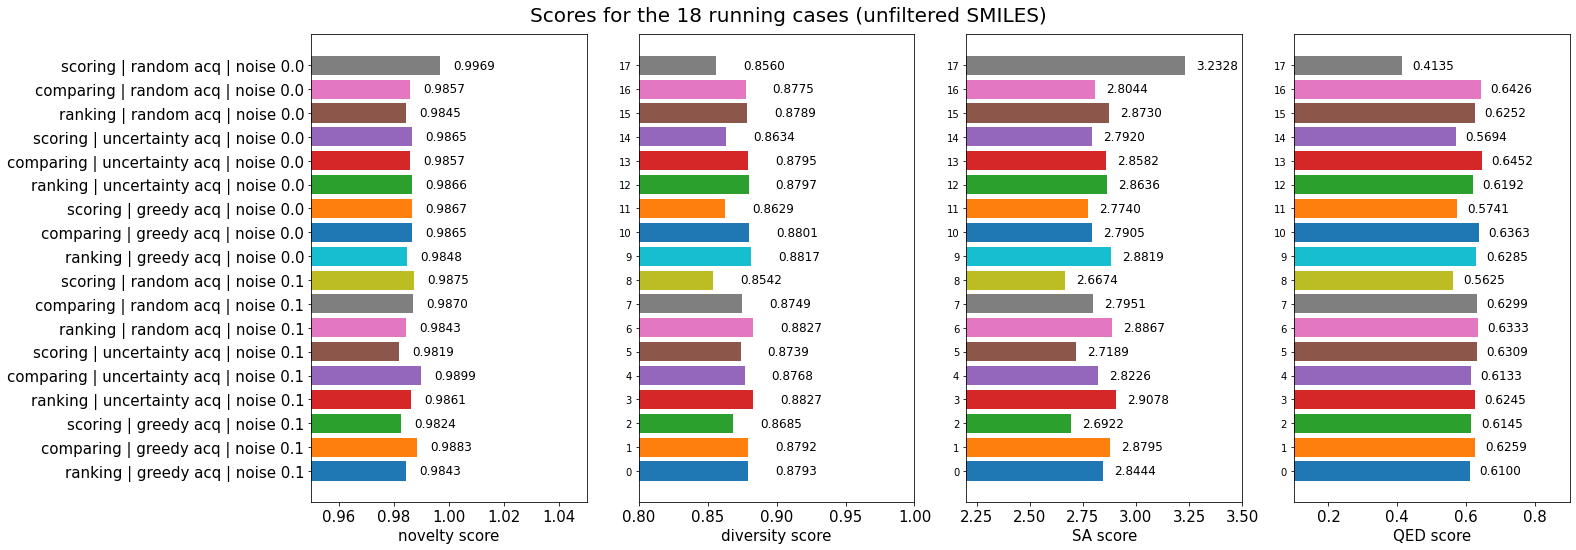

In [153]:
running_case = [
    ("score_regression", "random", "0.0"),
    ("bradley_terry", "random", "0.0"),
    ("rank_listnet", "random", "0.0"),
    ("score_regression", "uncertainty", "0.0"),
    ("bradley_terry", "uncertainty", "0.0"),
    ("rank_listnet", "uncertainty", "0.0"),
    ("score_regression", "greedy", "0.0"),
    ("bradley_terry", "greedy", "0.0"),
    ("rank_listnet", "greedy", "0.0"),
    ("score_regression", "random", "0.1"),
    ("bradley_terry", "random", "0.1"),
    ("rank_listnet", "random", "0.1"),
    ("score_regression", "uncertainty", "0.1"),
    ("bradley_terry", "uncertainty", "0.1"),
    ("rank_listnet", "uncertainty", "0.1"),
    ("score_regression", "greedy", "0.1"),
    ("bradley_terry", "greedy", "0.1"),
    ("rank_listnet", "greedy", "0.1")

]

model_name_mapping = {
    "score_regression": "scoring",
    "bradley_terry": "comparing",
    "rank_listnet": "ranking"
}
# Now we reverse the list 

running_case = running_case[::-1]

# Plot accuracy at threshold 0.75 for 18 running case (bar plot)

fig, ax = plt.subplots(1, 4, figsize=(22, 8))
fig.suptitle("Scores for the 18 running cases (unfiltered SMILES)", fontsize=20)
ax = ax.flatten()
index = 0

for score_name in ["novelty", "diversity", "SA", "QED"]:
    for i, case in enumerate(running_case):
        if score_name == "novelty":
            score_value = unfiltered_novelty_score_dict[case[0]][f"acq_{case[1]}_noise_{case[2]}"]
        elif score_name == "diversity":
            score_value = unfiltered_diversity_score_dict[case[0]][f"acq_{case[1]}_noise_{case[2]}"]
        elif score_name == "SA":
            score_value = unfiltered_sa_score_dict[case[0]][f"acq_{case[1]}_noise_{case[2]}"]
        elif score_name == "QED":
            score_value = unfiltered_qed_score_dict[case[0]][f"acq_{case[1]}_noise_{case[2]}"]
        
        ax[index].barh(i, score_value)
        if score_name == "novelty":
            ax[index].text(score_value + 0.02, i, f'{score_value:.4f}', va='center', ha='right', fontsize=12)
        elif score_name == "diversity":
            ax[index].text(score_value + 0.05, i, f'{score_value:.4f}', va='center', ha='right', fontsize=12)
        elif score_name == "SA":
            ax[index].text(score_value + 0.25, i, f'{score_value:.4f}', va='center', ha='right', fontsize=12)
        elif score_name == "QED":
            ax[index].text(score_value + 0.15, i, f'{score_value:.4f}', va='center', ha='right', fontsize=12)      


    ax[index].set_yticks(range(len(running_case)))
    if score_name == "novelty":
        ax[index].set_yticklabels([f"{model_name_mapping[case[0]]} | {case[1]} acq | noise {case[2]}" for case in running_case], fontsize = 15)
    # change x label fontsize
    ax[index].tick_params(axis='x', labelsize=15)
    if score_name == "novelty":
        ax[index].set_xlim([0.95, 1.05])
    elif score_name == "diversity":
        ax[index].set_xlim([0.8, 1.0])
    elif score_name == "SA":
        ax[index].set_xlim([2.2, 3.5])
    elif score_name == "QED":
        ax[index].set_xlim([0.1, 0.9])


    ax[index].set_xlabel(f"{score_name} score", fontsize=15)
    #ax[index].legend()

    index += 1
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

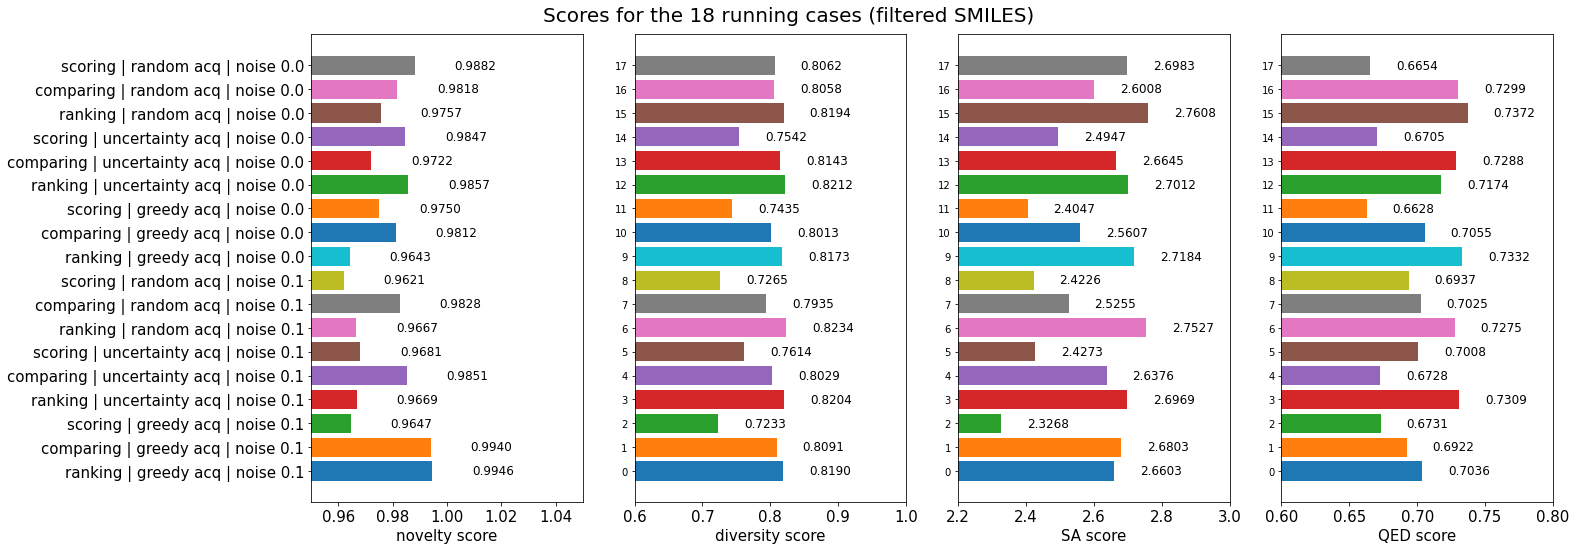

In [154]:
running_case = [
    ("score_regression", "random", "0.0"),
    ("bradley_terry", "random", "0.0"),
    ("rank_listnet", "random", "0.0"),
    ("score_regression", "uncertainty", "0.0"),
    ("bradley_terry", "uncertainty", "0.0"),
    ("rank_listnet", "uncertainty", "0.0"),
    ("score_regression", "greedy", "0.0"),
    ("bradley_terry", "greedy", "0.0"),
    ("rank_listnet", "greedy", "0.0"),
    ("score_regression", "random", "0.1"),
    ("bradley_terry", "random", "0.1"),
    ("rank_listnet", "random", "0.1"),
    ("score_regression", "uncertainty", "0.1"),
    ("bradley_terry", "uncertainty", "0.1"),
    ("rank_listnet", "uncertainty", "0.1"),
    ("score_regression", "greedy", "0.1"),
    ("bradley_terry", "greedy", "0.1"),
    ("rank_listnet", "greedy", "0.1")

]

model_name_mapping = {
    "score_regression": "scoring",
    "bradley_terry": "comparing",
    "rank_listnet": "ranking"
}
# Now we reverse the list 

running_case = running_case[::-1]

# Plot accuracy at threshold 0.75 for 18 running case (bar plot)

fig, ax = plt.subplots(1, 4, figsize=(22, 8))
fig.suptitle("Scores for the 18 running cases (filtered SMILES)", fontsize=20)
ax = ax.flatten()
index = 0

for score_name in ["novelty", "diversity", "SA", "QED"]:
    for i, case in enumerate(running_case):
        if score_name == "novelty":
            score_value = filtered_novelty_score_dict[case[0]][f"acq_{case[1]}_noise_{case[2]}"]
        elif score_name == "diversity":
            score_value = filtered_diversity_score_dict[case[0]][f"acq_{case[1]}_noise_{case[2]}"]
        elif score_name == "SA":
            score_value = filtered_sa_score_dict[case[0]][f"acq_{case[1]}_noise_{case[2]}"]
        elif score_name == "QED":
            score_value = filtered_qed_score_dict[case[0]][f"acq_{case[1]}_noise_{case[2]}"]
        
        ax[index].barh(i, score_value)
        if score_name == "novelty":
            ax[index].text(score_value + 0.03, i, f'{score_value:.4f}', va='center', ha='right', fontsize=12)
        elif score_name == "diversity":
            ax[index].text(score_value + 0.1, i, f'{score_value:.4f}', va='center', ha='right', fontsize=12)
        elif score_name == "SA":
            ax[index].text(score_value + 0.2, i, f'{score_value:.4f}', va='center', ha='right', fontsize=12)
        elif score_name == "QED":
            ax[index].text(score_value + 0.05, i, f'{score_value:.4f}', va='center', ha='right', fontsize=12)      


    ax[index].set_yticks(range(len(running_case)))
    if score_name == "novelty":
        ax[index].set_yticklabels([f"{model_name_mapping[case[0]]} | {case[1]} acq | noise {case[2]}" for case in running_case], fontsize = 15)
    # change x label fontsize
    ax[index].tick_params(axis='x', labelsize=15)
    if score_name == "novelty":
        ax[index].set_xlim([0.95, 1.05])
    elif score_name == "diversity":
        ax[index].set_xlim([0.6, 1.0])
    elif score_name == "SA":
        ax[index].set_xlim([2.2, 3.0])
    elif score_name == "QED":
        ax[index].set_xlim([0.6, 0.8])


    ax[index].set_xlabel(f"{score_name} score", fontsize=15)
    #ax[index].legend()

    index += 1
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

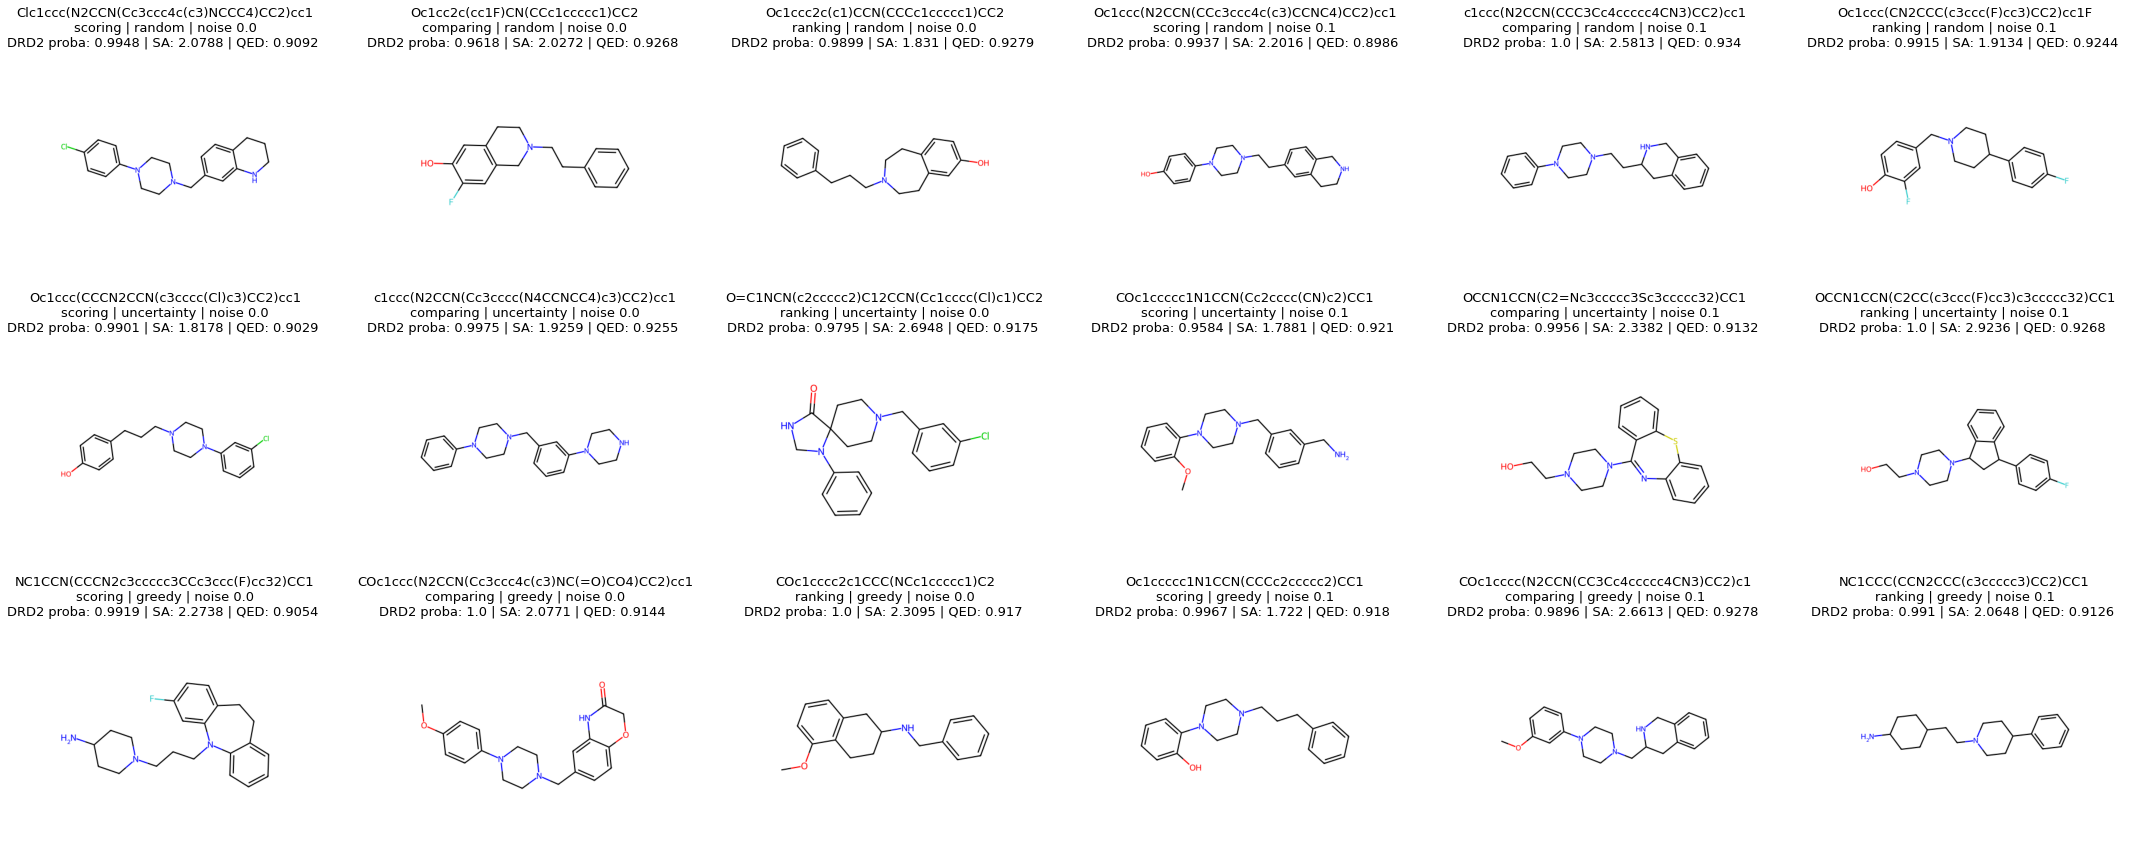

In [83]:
import os
import shutil
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D

# Assuming `filtered_models` and `model_names` are defined elsewhere in your code

# def draw_one_molecule(smile, legend_name):
#     mol = Chem.MolFromSmiles(smile)
#     # change legend name fontsize
#     img = Draw.MolToImage(mol, legend=legend_name, fitImage=False, size=(400,400), legendFontSize=100)
#     return img

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image
import io
import matplotlib.pyplot as plt

def draw_one_molecule(smile, legend_name):
    mol = Chem.MolFromSmiles(smile)
    d2d = rdMolDraw2D.MolDraw2DCairo(400, 400)
    dopts = d2d.drawOptions()
    dopts.legendFontSize = 100  # Set the desired font size
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    img = d2d.GetDrawingText()
    img = Image.open(io.BytesIO(img))
    return img

fig, ax = plt.subplots(3, 6, figsize=(30, 12))
ax = ax.flatten()
index = 0

model_names_mapping = {
    "score_regression": "scoring",
    "bradley_terry": "comparing",
    "rank_listnet": "ranking"
}

for acquisition in ["random", "uncertainty", "greedy"]:
    for sigma_noise in [0.0, 0.1]:
        for model_name in model_names:
            # Create the figure and axes once for each acquisition and noise combination

            smiles_list = filtered_combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["smiles_list"]
            drd2_probas = filtered_combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["drd2_proba"]
            qed_scores = filtered_qed_score_dict_list[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]
            sa_scores = filtered_sa_score_dict_list[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]
            
            # Then we sort them by QED score (higher the better)
            sorted_indices = sorted(range(len(qed_scores)), key=lambda i: qed_scores[i], reverse=True)[:20]
            # Then we sort them by SA scores (lower the better)
            sorted_indices = sorted(sorted_indices, key=lambda i: sa_scores[i], reverse=False)[:10]
            # We will sort by DRD2 probability (higher the better)
            sorted_indices = sorted(sorted_indices, key=lambda i: drd2_probas[i], reverse=True)
            
            
            max_index = sorted_indices[0]
            smile = smiles_list[max_index]
            props = {prop: filtered_combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"][prop][max_index] for prop in [
                "drd2_proba", "logP", "mol_weight", "h_donors", "h_acceptors", "tpsa", "rotatable_bonds", "num_rings"]}
            drd2_proba = props["drd2_proba"]
            qed_score = qed_scores[max_index]
            sa_score = sa_scores[max_index]
            legend_name = f"{smile}\n{model_names_mapping[model_name]} | {acquisition} | noise {sigma_noise}\nDRD2 proba: {round(drd2_proba, 4)} | SA: {round(sa_score, 4)} | QED: {round(qed_score, 4)} "
            img = draw_one_molecule(smile, legend_name)
            ax[index].imshow(img)
            ax[index].set_title(legend_name, fontsize=13)
            ax[index].axis('off')
            index += 1
     
plt.tight_layout()
plt.show()


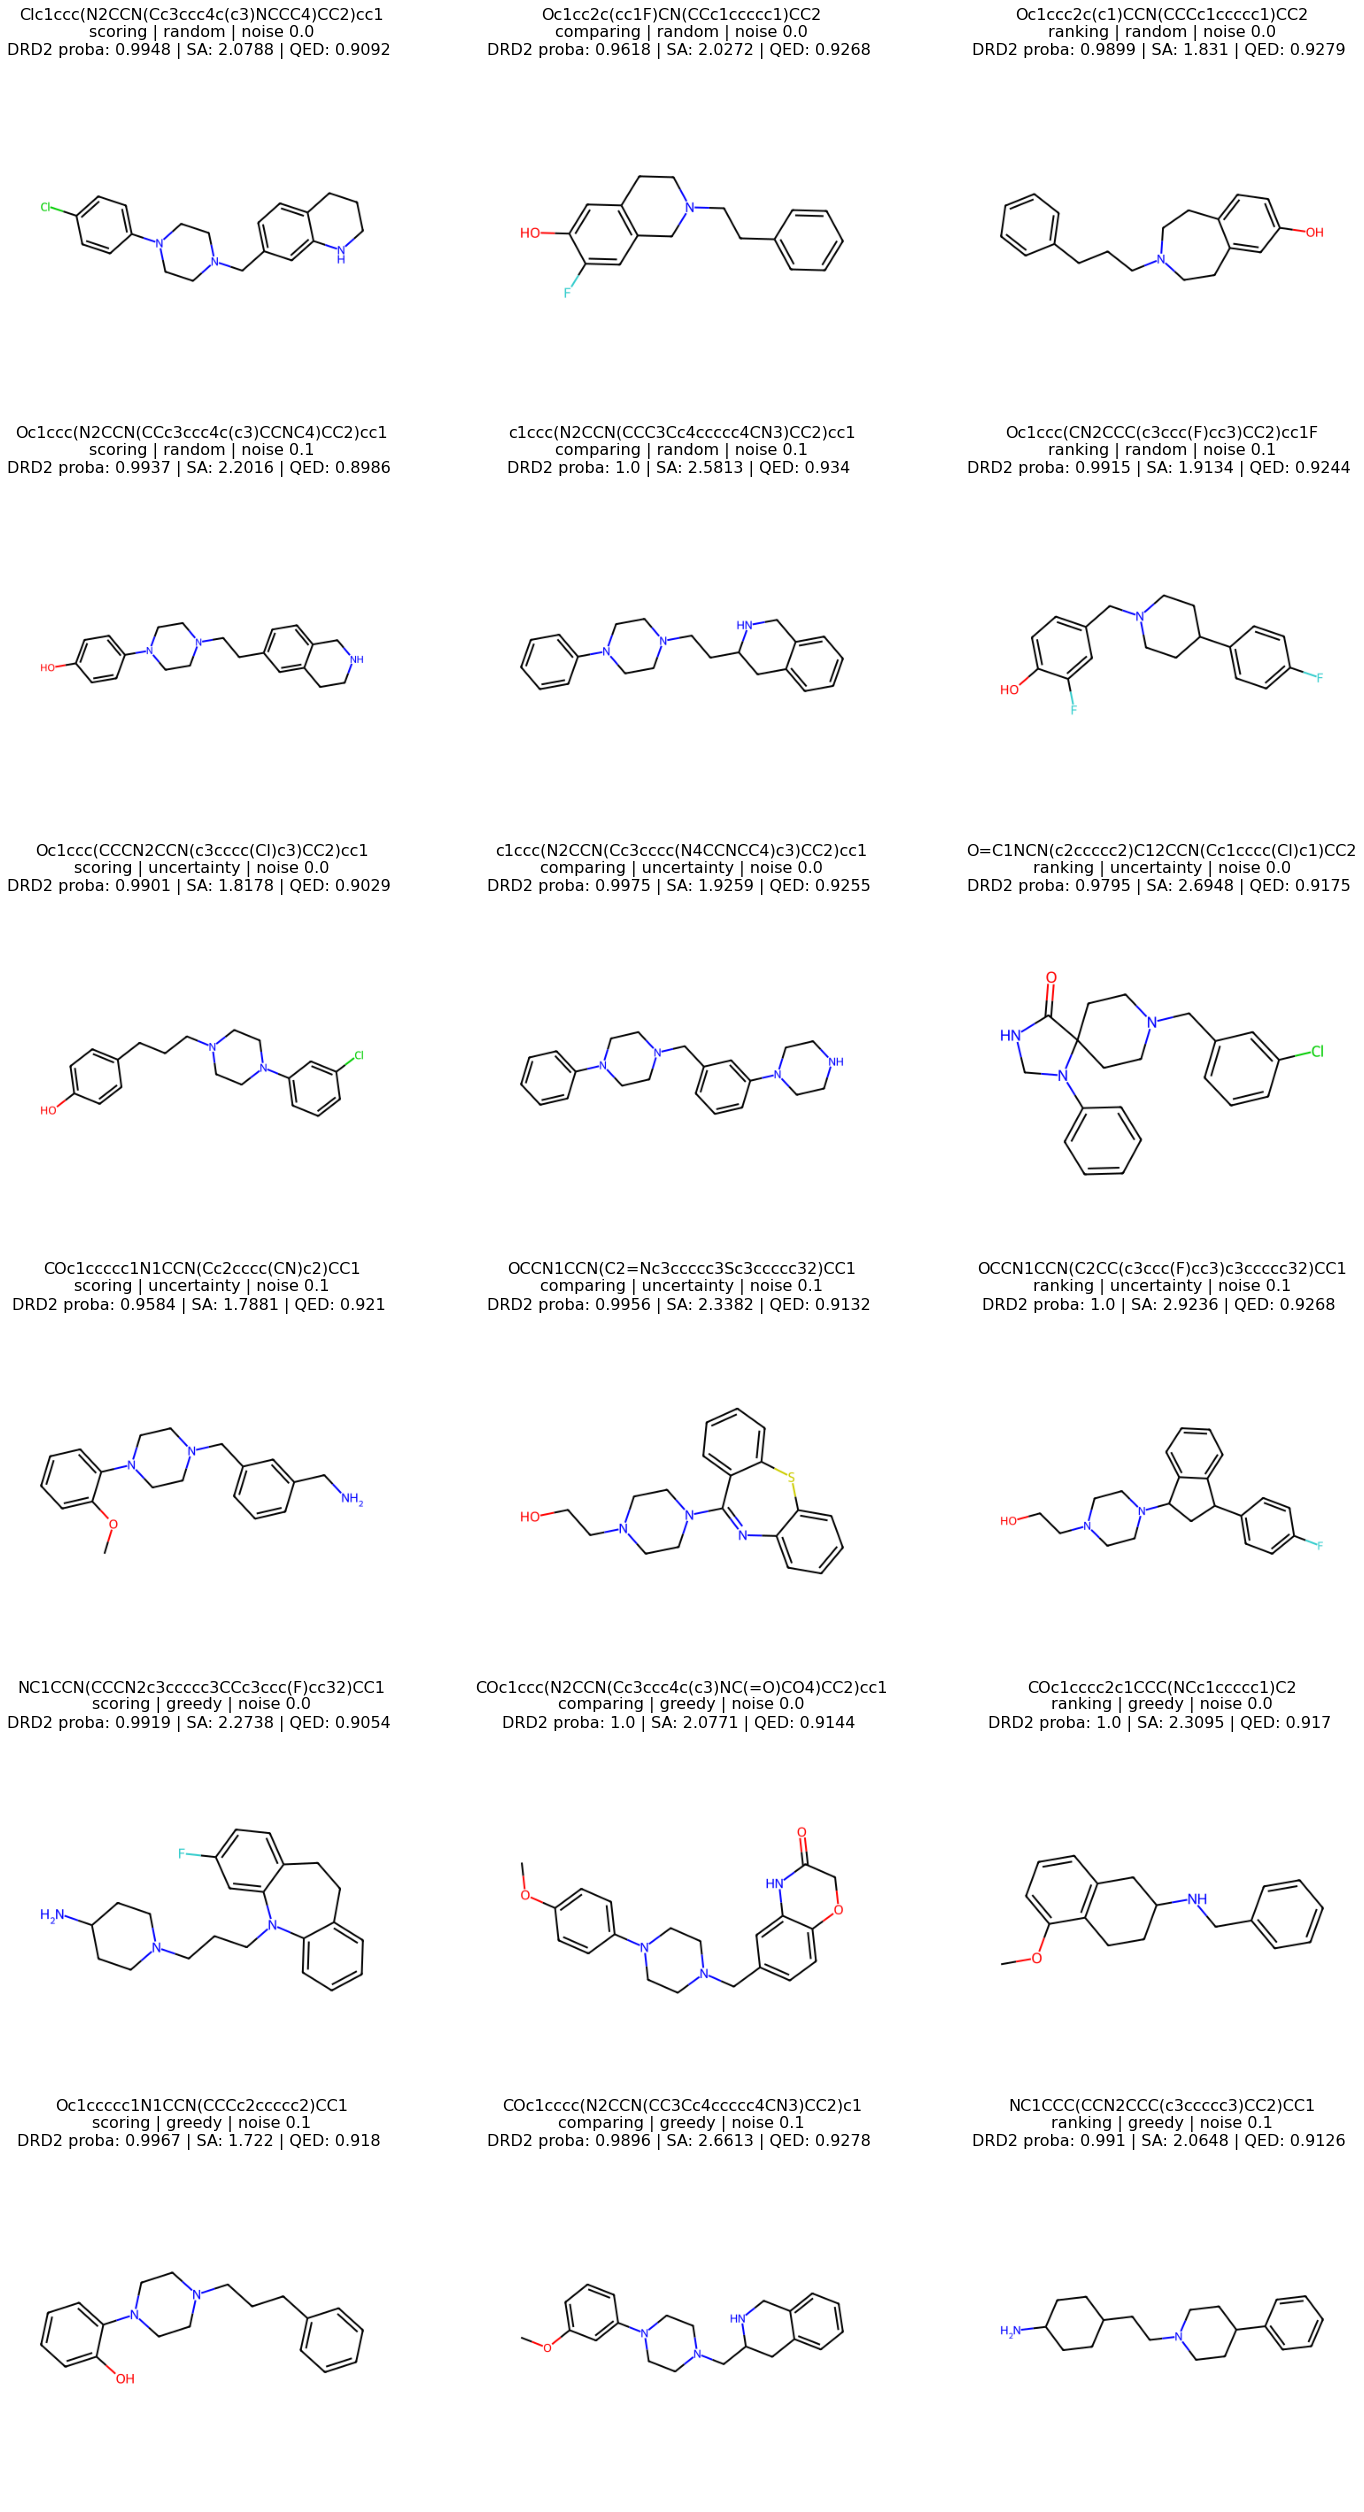

In [76]:
import os
import shutil
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D

# Assuming `filtered_models` and `model_names` are defined elsewhere in your code

# def draw_one_molecule(smile, legend_name):
#     mol = Chem.MolFromSmiles(smile)
#     # change legend name fontsize
#     img = Draw.MolToImage(mol, legend=legend_name, fitImage=False, size=(400,400), legendFontSize=100)
#     return img

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image
import io
import matplotlib.pyplot as plt

def draw_one_molecule(smile, legend_name):
    mol = Chem.MolFromSmiles(smile)
    d2d = rdMolDraw2D.MolDraw2DCairo(400, 400)
    dopts = d2d.drawOptions()
    dopts.legendFontSize = 100  # Set the desired font size
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    img = d2d.GetDrawingText()
    img = Image.open(io.BytesIO(img))
    return img

fig, ax = plt.subplots(6, 3, figsize=(20, 35))
ax = ax.flatten()
index = 0

model_names_mapping = {
    "score_regression": "scoring",
    "bradley_terry": "comparing",
    "rank_listnet": "ranking"
}

for acquisition in ["random", "uncertainty", "greedy"]:
    for sigma_noise in [0.0, 0.1]:
        for model_name in model_names:
            # Create the figure and axes once for each acquisition and noise combination

            smiles_list = filtered_combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["smiles_list"]
            drd2_probas = filtered_combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["drd2_proba"]
            qed_scores = filtered_qed_score_dict_list[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]
            sa_scores = filtered_sa_score_dict_list[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]
            
            # Then we sort them by QED score (higher the better)
            sorted_indices = sorted(range(len(qed_scores)), key=lambda i: qed_scores[i], reverse=True)[:20]
            # Then we sort them by SA scores (lower the better)
            sorted_indices = sorted(sorted_indices, key=lambda i: sa_scores[i], reverse=False)[:10]
            # We will sort by DRD2 probability (higher the better)
            sorted_indices = sorted(sorted_indices, key=lambda i: drd2_probas[i], reverse=True)
            
            
            max_index = sorted_indices[0]
            smile = smiles_list[max_index]
            props = {prop: filtered_combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"][prop][max_index] for prop in [
                "drd2_proba", "logP", "mol_weight", "h_donors", "h_acceptors", "tpsa", "rotatable_bonds", "num_rings"]}
            drd2_proba = props["drd2_proba"]
            qed_score = qed_scores[max_index]
            sa_score = sa_scores[max_index]
            legend_name = f"{smile}\n{model_names_mapping[model_name]} | {acquisition} | noise {sigma_noise}\nDRD2 proba: {round(drd2_proba, 4)} | SA: {round(sa_score, 4)} | QED: {round(qed_score, 4)} "
            img = draw_one_molecule(smile, legend_name)
            ax[index].imshow(img)
            ax[index].set_title(legend_name, fontsize=16)
            ax[index].axis('off')
            index += 1
    
plt.tight_layout()
plt.show()


In [15]:


### Draw the smiles using RDKit for filtered molecules
from rdkit.Chem import Draw

def draw_one_molecules(smile):
    mol = Chem.MolFromSmiles(smile)
    img = Draw.MolToImage(mol, legend=smile, size=(300, 300))
    return img

# Note that if there are too many filtered smiles, this would run forever!
run_this_cell = False

if run_this_cell:
    for i, model_name in enumerate(model_names):
        if os.path.exists(f"smiles_figure_{model_name}"):
            shutil.rmtree(f"smiles_figure_{model_name}")
        os.mkdir(f"smiles_figure_{model_name}")
        for acquisition in ["random", "uncertainty", "greedy"]:
            for sigma_noise in [0.0, 0.1]:
                os.makedirs(f"smiles_figure_{model_name}_n_steps_100/acq_{acquisition}_noise_{sigma_noise}", exist_ok=True)
                for REINVENT_round in [4]:
                    os.makedirs(f"smiles_figure_{model_name}_n_steps_100/acq_{acquisition}_noise_{sigma_noise}/REINVENT_round_{REINVENT_round}", exist_ok=True)
                    
                    REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
                    smiles_list = filtered_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["smiles_list"][REINVENT_round_name]
                    for i, smile in enumerate(smiles_list):
                        img = draw_one_molecules(smile)
                        img.save(f"smiles_figure_{model_name}_n_steps_100/acq_{acquisition}_noise_{sigma_noise}/REINVENT_round_{REINVENT_round}/molecule_{i+1}.png")



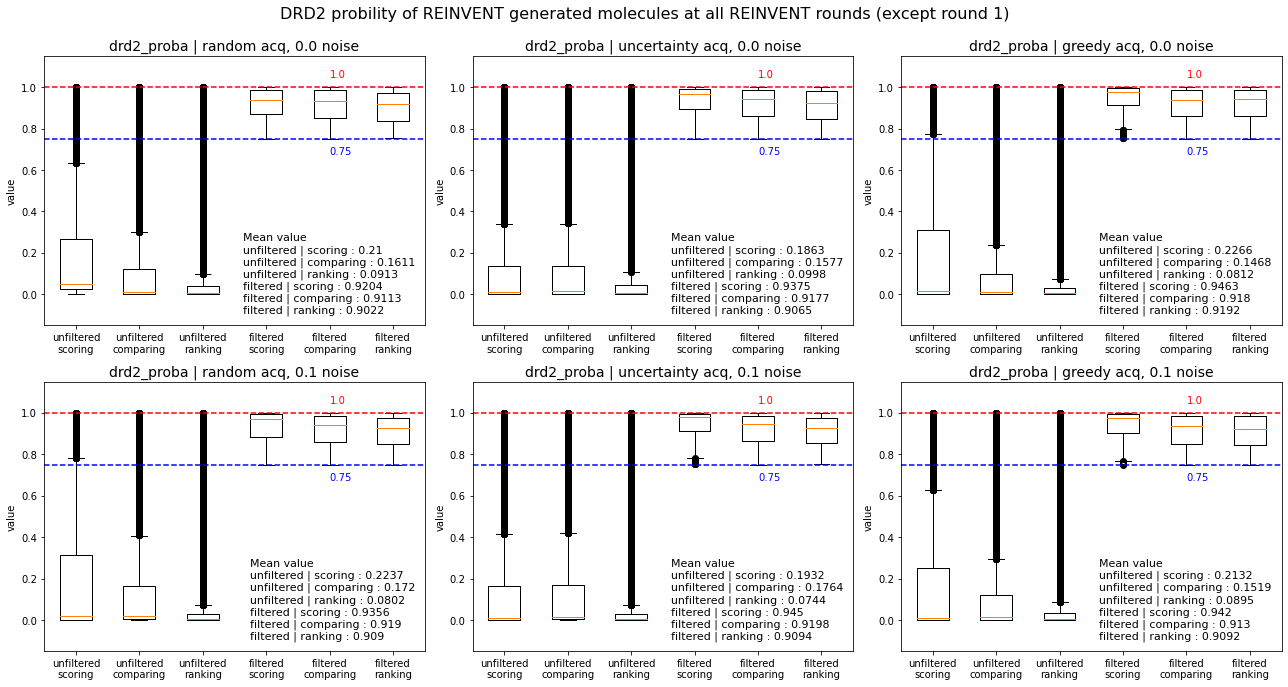

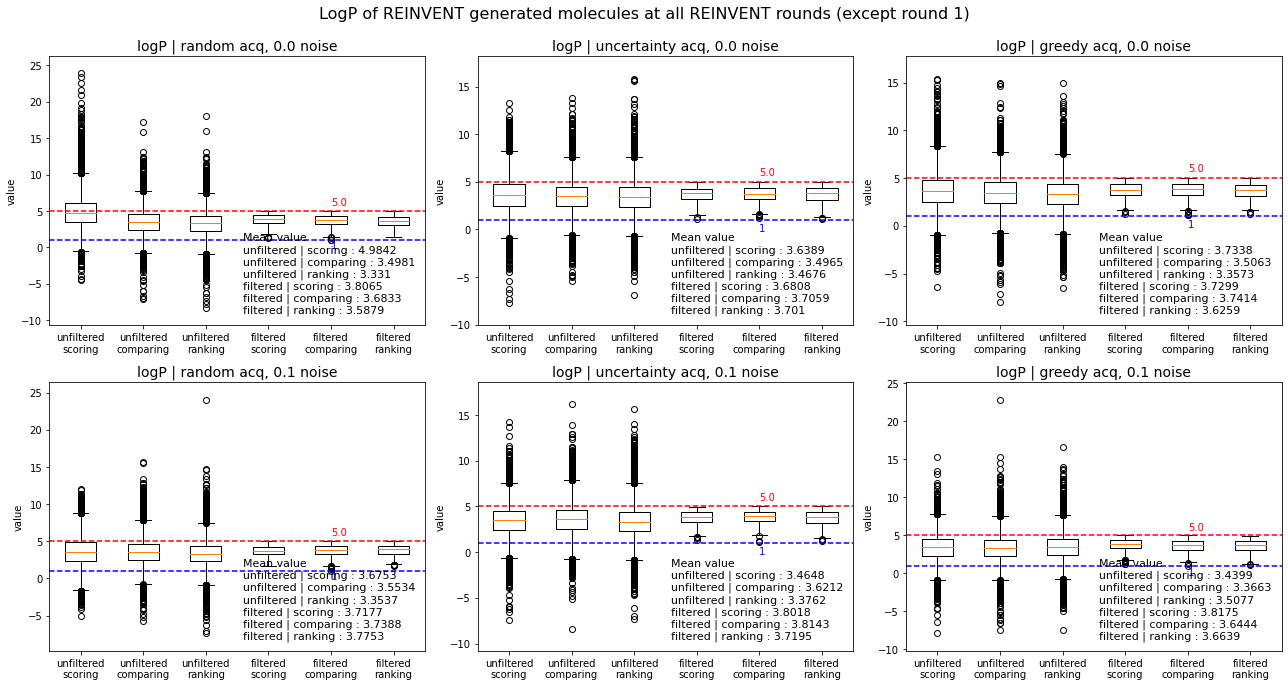

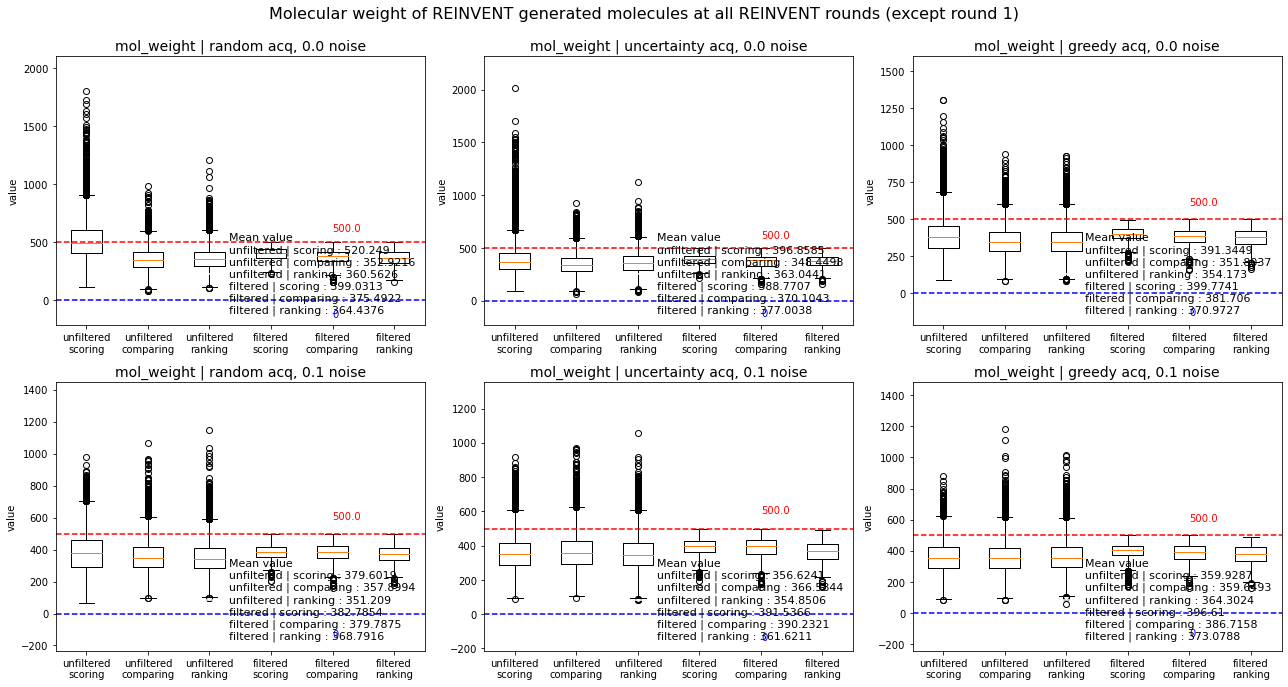

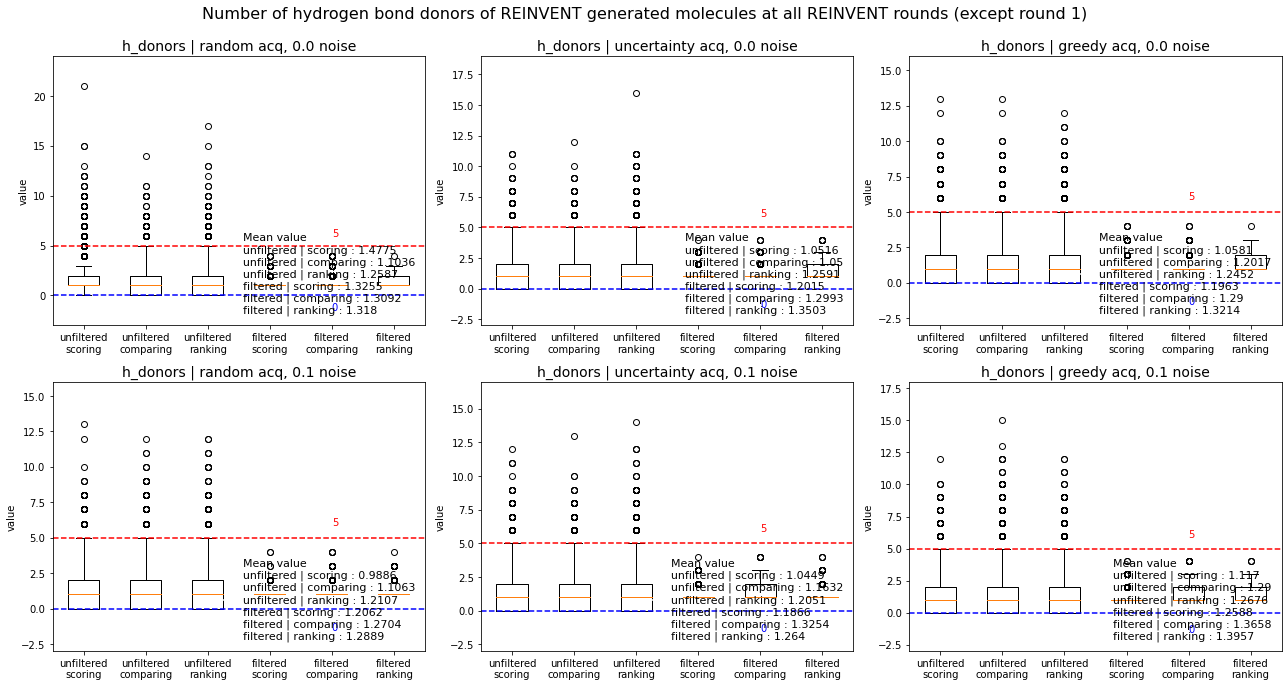

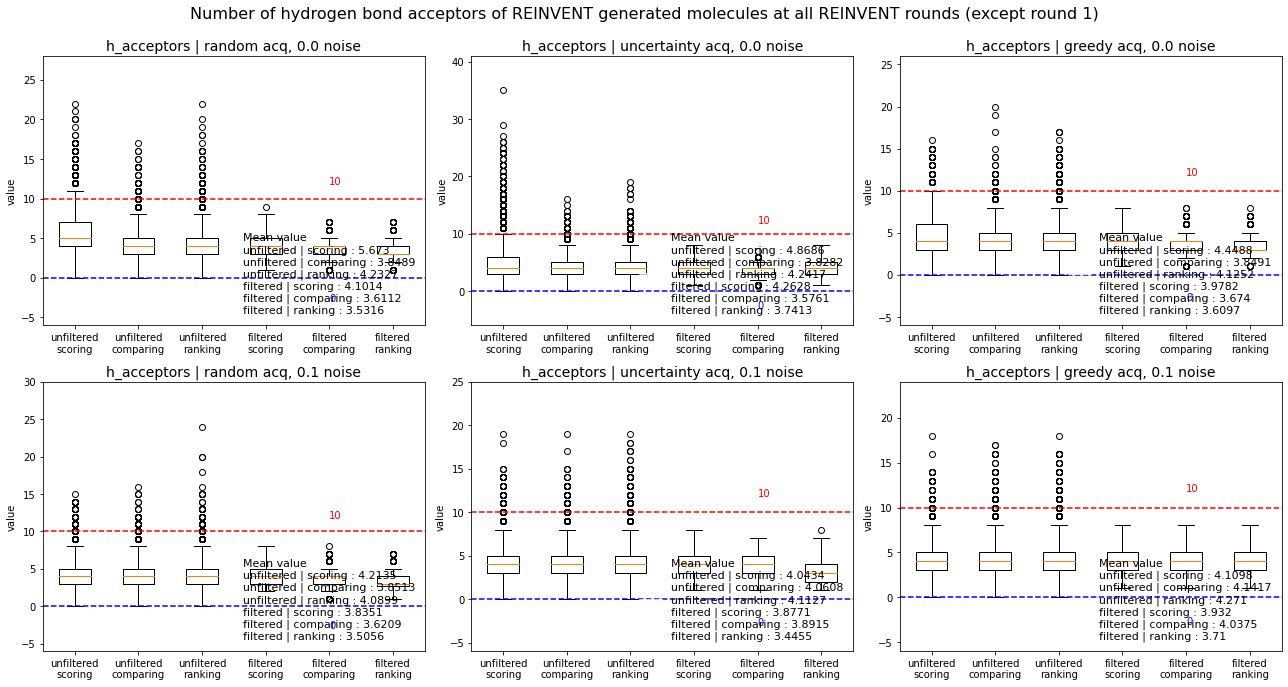

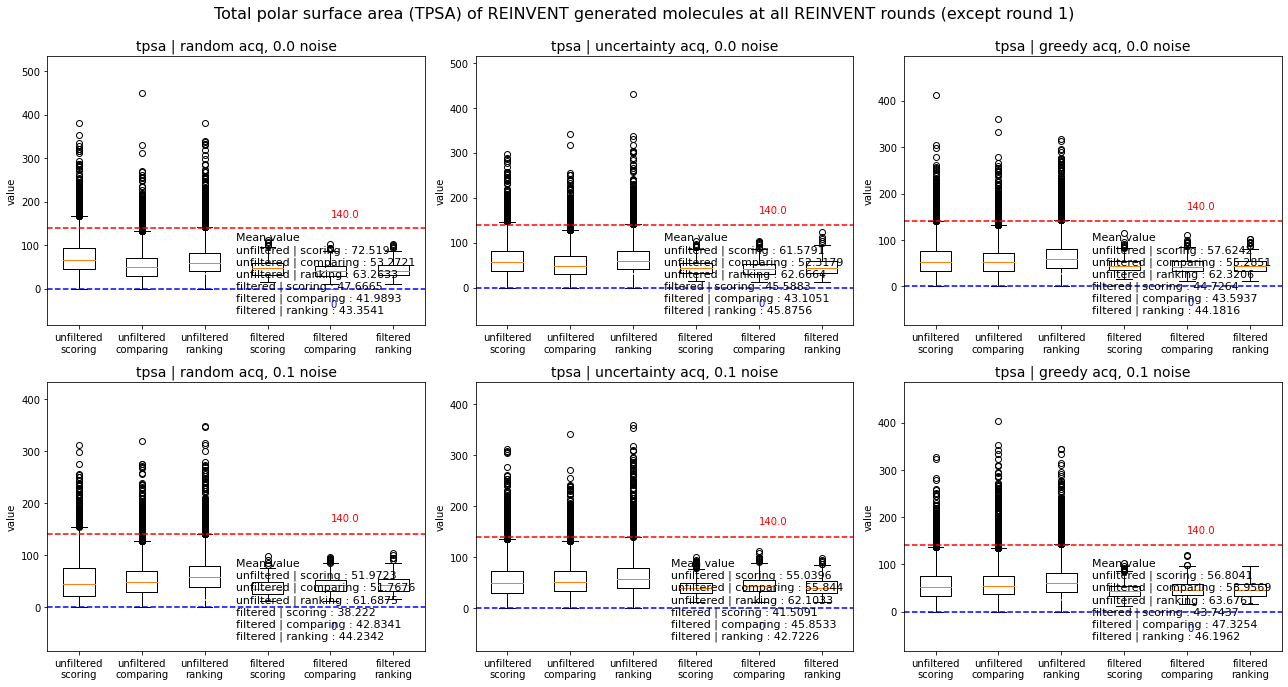

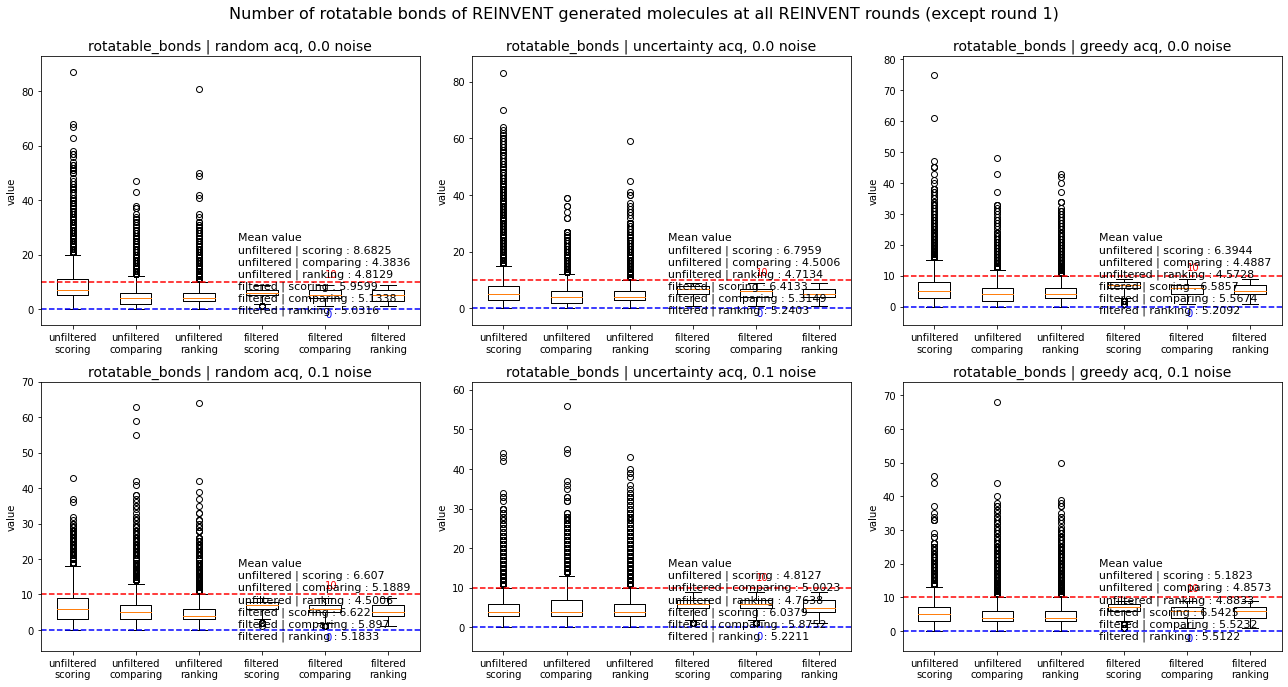

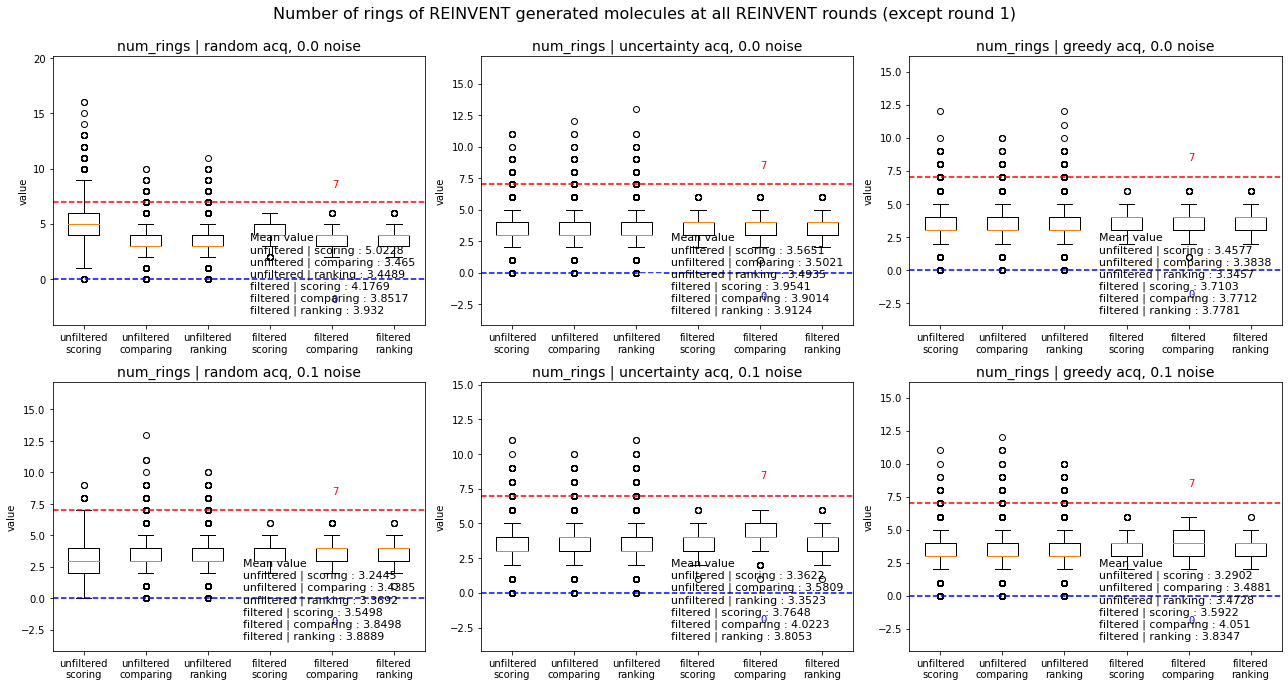

In [97]:
prop_names = ["drd2_proba", "logP", "mol_weight", "h_donors", "h_acceptors", "tpsa", "rotatable_bonds", "num_rings"]

lower_bounds = {
    "drd2_proba": 0.75,  # No lower limit, set to your preference
    "logP": 1,  # No practical lower limit, but logP can be negative
    "mol_weight": 0,  # Molecules can technically weigh very little
    "h_donors": 0,  # Hydrogen bond donors can be zero
    "h_acceptors": 0,  # Hydrogen bond acceptors can be zero
    "tpsa": 0,  # Total polar surface area can be zero
    "rotatable_bonds": 0,  # Rotatable bonds can be zero
    "num_rings": 0  # Number of rings can be zero
}

upper_bounds = {
    "drd2_proba": 1.0,  # Maximum for a probability score
    "logP": 5.0,  # Lipinski's rule of five
    "mol_weight": 500.0,  # Lipinski's rule of five
    "h_donors": 5,  # Lipinski's rule of five
    "h_acceptors": 10,  # Lipinski's rule of five
    "tpsa": 140.0,  # Veber's rule
    "rotatable_bonds": 10,  # Veber's rule
    "num_rings": 7  # Muegge’s rule
}

prop_name_mapping = {
    "drd2_proba": "DRD2 probility",
    "logP": "LogP",
    "mol_weight": "Molecular weight",
    "h_donors": "Number of hydrogen bond donors",
    "h_acceptors":  "Number of hydrogen bond acceptors",
    "tpsa": "Total polar surface area (TPSA)",
    "rotatable_bonds": "Number of rotatable bonds",
    "num_rings": "Number of rings"
}


for prop_name in prop_names:

    fig, ax = plt.subplots(2, 3, figsize=(18, 10))

    # Flatten ax
    ax = ax.flatten()

    # Subplot title
    fig.suptitle(f"{prop_name_mapping[prop_name]} of REINVENT generated molecules at all REINVENT rounds (except round 1)", fontsize=16)

    index = 0
    for sigma_noise in [0.0, 0.1]:
        for acquisition in ["random", "uncertainty", "greedy"]:
            unfiltered_prop_scoring = combined_models["score_regression"][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name]
            unfiltered_prop_comparing = combined_models["bradley_terry"][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name]
            unfiltered_prop_ranking = combined_models["rank_listnet"][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name]

            filtered_prop_scoring = filtered_combined_models["score_regression"][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name]
            filtered_prop_comparing = filtered_combined_models["bradley_terry"][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name]
            filtered_prop_ranking = filtered_combined_models["rank_listnet"][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name]

            # Creating a box plot
            ax[index].boxplot([unfiltered_prop_scoring, unfiltered_prop_comparing, unfiltered_prop_ranking,
                               filtered_prop_scoring, filtered_prop_comparing, filtered_prop_ranking,
                               ], 
                              labels=['unfiltered\nscoring', 'unfiltered\ncomparing', 'unfiltered\nranking',
                                        'filtered\nscoring', 'filtered\ncomparing', 'filtered\nranking'])

            # Turn on grid for each subplot
            #ax[index].grid()
            range_lim = (upper_bounds[prop_name] - lower_bounds[prop_name]) * 0.6
            # set only the top limit if only max(unfiltered) > max(filtered)
            #if max(max(unfiltered_prop_scoring), max(unfiltered_prop_comparing), max(unfiltered_prop_ranking)) > max(max(filtered_prop_scoring), max(filtered_prop_comparing), max(filtered_prop_ranking)):
            ax[index].set_ylim(top=max(max(unfiltered_prop_scoring), max(unfiltered_prop_comparing), max(unfiltered_prop_ranking)) + range_lim)
            
            # set only the bottom limit if only min(unfiltered) < min(filtered)
            #if min(min(unfiltered_prop_scoring), min(unfiltered_prop_comparing), min(unfiltered_prop_ranking)) < min(min(filtered_prop_scoring), min(filtered_prop_comparing), min(filtered_prop_ranking)):
            ax[index].set_ylim(bottom=min(min(unfiltered_prop_scoring), min(unfiltered_prop_comparing), min(unfiltered_prop_ranking)) - range_lim)

                        

            # Draw lower bound with blue color
            ax[index].axhline(y=lower_bounds[prop_name], color='b', linestyle='--')
            # Annotate the lower bound value
            ax[index].text(5, lower_bounds[prop_name] - range_lim * 0.5, f"{lower_bounds[prop_name]}", color='b')

            # Draw upper bound with red color
            ax[index].axhline(y=upper_bounds[prop_name], color='r', linestyle='--')
            # Annotate the upper bound value
            ax[index].text(5, upper_bounds[prop_name] + range_lim * 0.3, f"{upper_bounds[prop_name]}", color='r')

            ax[index].set_title(f"{prop_name} | {acquisition} acq, {sigma_noise} noise", fontsize=14)
            ax[index].set_ylabel("value")
            
            ax[index].plot([],[], color="white", label=f"Mean value\nunfiltered | scoring : {round(np.mean(unfiltered_prop_scoring), 4)}\n\
unfiltered | comparing : {round(np.mean(unfiltered_prop_comparing), 4)}\n\
unfiltered | ranking : {round(np.mean(unfiltered_prop_ranking), 4)}\n\
filtered | scoring : {round(np.mean(filtered_prop_scoring), 4)}\n\
filtered | comparing : {round(np.mean(filtered_prop_comparing), 4)}\n\
filtered | ranking : {round(np.mean(filtered_prop_ranking), 4)}")
            ax[index].legend(fontsize=11, frameon = False, loc=4)
            index += 1

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()